In [1]:
"""
original kaggle competition page

https://www.kaggle.com/competitions/shotquality-rebounding/leaderboard
"""

'\noriginal kaggle competition page\n\nhttps://www.kaggle.com/competitions/shotquality-rebounding/leaderboard\n'

# Offensive Rebound Prediction Project

In this project, we will attempt to predict offensive rebound outcomes in NCAA basketball plays. We have downloaded a dataset from Kaggle.com that includes over 300,000 rows of basketball plays to train our models off of.

### Table of Contents

1.) Exploratory Data Analysis (EDA) and Data Cleaning<br>
2.) Simple Modeling/Baseline Model<br>
3.) Feature Engineering<br>
4.) More Complex Feature Engineering<br>
5.) Model Experimentation with Hyperparameter Tuning<br>
6.) Convolutional Neural Network<br>
7.) Conclusion<br>

In [92]:
# basic libraries
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import make_scorer, log_loss, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, initializers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# PIL for Image Handling
from PIL import Image

In [3]:
sample_submission = pd.read_csv('data/sample_sumbission.csv')
test_locs = pd.read_csv('data/test_locs.csv')
train_locs = pd.read_csv('data/train_locs.csv')
test_pbp = pd.read_csv('data/test_pbp.csv')
train_pbp = pd.read_csv('data/train_pbp.csv')

pd.options.mode.chained_assignment = None  # default='warn'

# 1.) Exploratory Data Analysis (EDA) and Data Cleaning

In this section, we will clean and explore the dataset that we are working with

In [4]:
train_locs.head()

,id,court_x,court_y,annotation_code
0,2-2,72.807686,37.409669,d1
1,2-2,79.080643,31.477796,d2
2,2-2,69.956321,24.467300,d3
3,2-2,75.468933,13.861763,d4
4,2-2,84.973496,19.254422,d5


The locs dataset is formatted such that each group of ten rows represents one basketball play, and each row within each play group represents a singular player. Each row has data on the x and y coordinates when the ball leaves the shooters hand, and and 'annotation_code' which denotes whether a player is a defensive player (d), offensive player (o), or shooter (s).

In [5]:
train_pbp.head()

,id,is_oreb,team,opponent,conference,opp_conference
0,2-2,0,Kentucky,Duke,SEC,ACC
1,2-3,0,Duke,Kentucky,ACC,SEC
2,2-4,0,Kentucky,Duke,SEC,ACC
3,2-6,1,Kentucky,Duke,SEC,ACC
4,2-8,0,Kentucky,Duke,SEC,ACC


The pbp (play-by-play) dataset is formatted such that each row represents one basektball play (contains the same plays as the locs dataset). Each row has data on whether or not there was an offensive board on this particular play, which teams were playing, and which conference either team is in.

### Creating Columns for Visualizations

In [6]:
# create copies of original dataframes
training_data = train_locs.copy()
testing_data = test_locs.copy()

In [7]:
# assign 1 if the player is on the offensive team and 0 if on the defensive team
training_data['offense'] = training_data['annotation_code'].apply(lambda x: 0 if 'd' in x else 1)
testing_data['offense'] = testing_data['annotation_code'].apply(lambda x: 0 if 'd' in x else 1)
# assign 1 if the player is the shooter (based on 'annotation_code' containing 's') and 0 otherwise.
training_data['shooter'] = training_data['annotation_code'].apply(lambda x: 1 if 's' in x else 0)
testing_data['shooter'] = testing_data['annotation_code'].apply(lambda x: 1 if 's' in x else 0)

In [8]:
training_data

,id,court_x,court_y,annotation_code,offense,shooter
0,2-2,72.807686,37.409669,d1,0,0
1,2-2,79.080643,31.477796,d2,0,0
2,2-2,69.956321,24.467300,d3,0,0
3,2-2,75.468933,13.861763,d4,0,0
4,2-2,84.973496,19.254422,d5,0,0
...,...,...,...,...,...,...
308045,5020-52,70.669644,7.270347,s,1,1
308046,5020-52,86.958520,4.382292,t1,1,0
308047,5020-52,58.962087,26.764930,t2,1,0
308048,5020-52,76.777949,20.427222,t3,1,0


In [9]:
# define the coordinates of the hoop
hoop_coordinates = np.array([[4, 25], [90, 25]])

# calculate the distance of each shot from the basket
def calculate_shooter_distance_from_hoop(row):
    shot_coordinates = np.array([row['court_x'], row['court_y']])
    distance = np.linalg.norm(shot_coordinates - hoop_coordinates, axis=1)
    if distance[0] < distance[1]:
        # 0 for hoop at (4, 25)
        hoop = 0
    else:
        # 1 for hoop at (90, 25)
        hoop = 1
    return pd.Series([np.min(distance), hoop])

In [10]:
# keeping only rows for the shooter in each play
shooter_data_train = training_data.loc[training_data.annotation_code == 's']
shooter_data_test = testing_data.loc[testing_data.annotation_code == 's']
# hoop at x = 4 is 0, x = 90 is 1
shooter_data_train[['shooter_dist_from_hoop', 'which_hoop']] = shooter_data_train.apply(calculate_shooter_distance_from_hoop, axis=1)
shooter_data_test[['shooter_dist_from_hoop', 'which_hoop']] = shooter_data_test.apply(calculate_shooter_distance_from_hoop, axis=1)
# splitting id so that we can group by game
shooter_data_train['game_number'] = shooter_data_train['id'].str.split('-').str[0]
shooter_data_train['play_number'] = shooter_data_train['id'].str.split('-').str[1]

In [11]:
# ensuring columns are added
shooter_data_train

# this dataset allows us to just focus on visualizations for shooters

,id,court_x,court_y,annotation_code,offense,shooter,shooter_dist_from_hoop,which_hoop,game_number,play_number
5,2-2,69.994331,39.674616,s,1,1,24.810706,1.0,2,2
15,2-3,16.896578,13.154704,s,1,1,17.510933,0.0,2,3
25,2-4,87.963438,3.638889,s,1,1,21.457974,1.0,2,4
35,2-6,80.185287,22.850748,s,1,1,10.047281,1.0,2,6
45,2-8,70.659638,39.791936,s,1,1,24.348532,1.0,2,8
...,...,...,...,...,...,...,...,...,...,...
308005,5020-46,75.406582,43.315000,s,1,1,23.418093,1.0,5020,46
308015,5020-47,34.976740,28.423749,s,1,1,31.165373,0.0,5020,47
308025,5020-48,12.023261,24.935416,s,1,1,8.023521,0.0,5020,48
308035,5020-49,63.025313,12.659930,s,1,1,29.663295,1.0,5020,49


### Distribution of Shot Locations

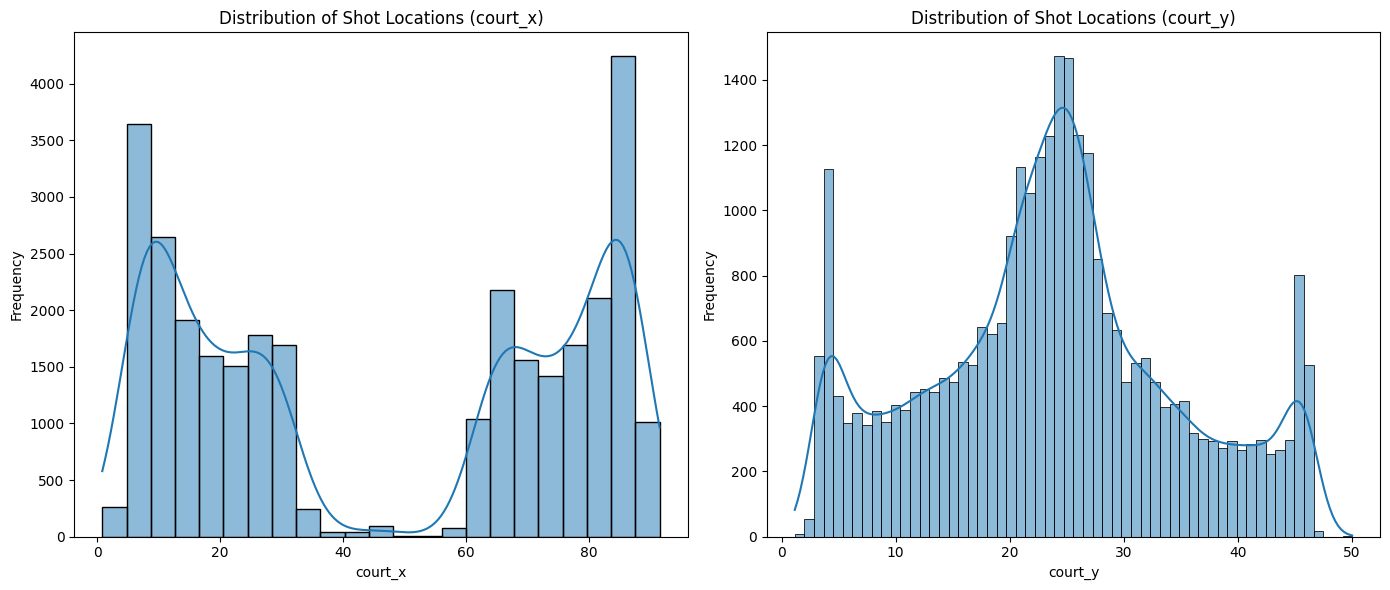

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(shooter_data_train['court_x'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Shot Locations (court_x)')
axes[0].set_xlabel('court_x')
axes[0].set_ylabel('Frequency')

sns.histplot(shooter_data_train['court_y'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Shot Locations (court_y)')
axes[1].set_xlabel('court_y')
axes[1].set_ylabel('Frequency')


plt.tight_layout() # Adjusts the plots so that they fit well
plt.show()

#### Distribution of Shot Locations Takeaways:
- Most shots are taken right next to the basket
- The least shots are taken around half court
- More layups and three points shots are taken than midrange shots
- The corner three is very popular
- The middle of the court (in the y direction) is more popular than the left and right sides of the court.

### Heatmap of Shot Locations

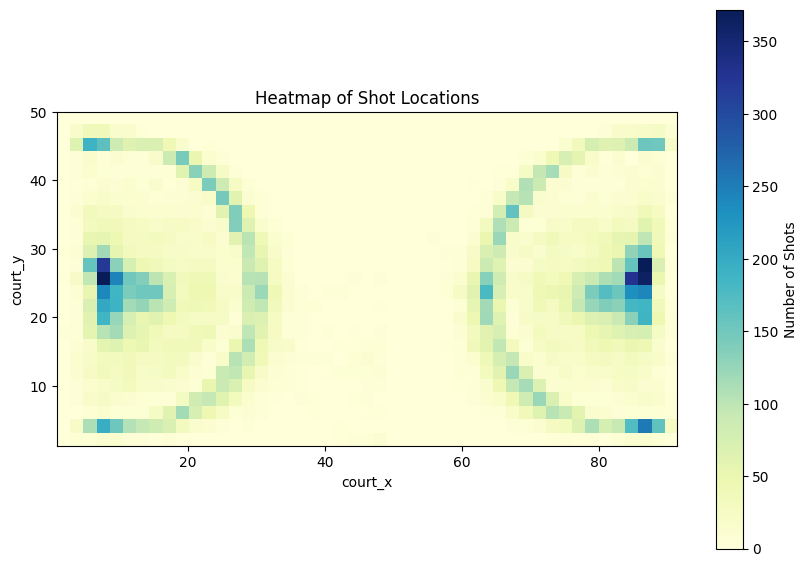

In [13]:
# define grid size for binning
grid_size = 2

# use numpy's histogram2d to bin the data
hist, xedges, yedges = np.histogram2d(shooter_data_train['court_x'], shooter_data_train['court_y'], bins=(int(94/grid_size), int(50/grid_size)))

# plot heatmap
plt.figure(figsize=(10, 7))
plt.imshow(hist.T, origin='lower', cmap='YlGnBu', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Number of Shots')
plt.title('Heatmap of Shot Locations')
plt.xlabel('court_x')
plt.ylabel('court_y')
plt.show()

#### Heatmap of Shot Locations Takeaways:
- Most shots are taken right next to the basket
- Three pointers are taken way more than midrange shots.

### Dot Plot of Shot Attempts

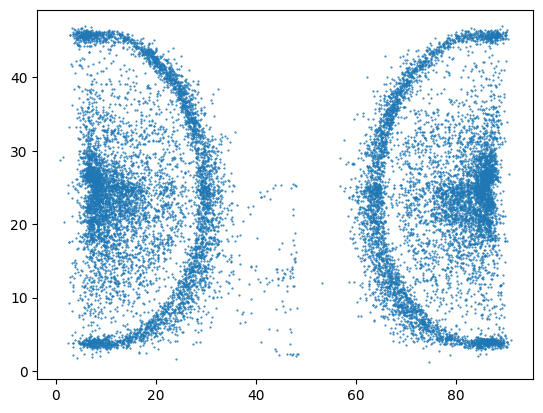

In [14]:
shooter_data_train_sample = shooter_data_train.sample(frac=0.50)
plt.scatter(shooter_data_train_sample['court_x'], shooter_data_train_sample['court_y'], marker = '.', s= 1)
# Where most shots happen

### Example of what the Floor Looks Like on Plays with Offensive Boards and Without Offensive Boards

In [15]:
# create dataframe with both locs and pbp data
example_floor_oreb = pd.merge(train_locs, train_pbp, on='id', how='left')
example_floor_oreb

,id,court_x,court_y,annotation_code,is_oreb,team,opponent,conference,opp_conference
0,2-2,72.807686,37.409669,d1,0,Kentucky,Duke,SEC,ACC
1,2-2,79.080643,31.477796,d2,0,Kentucky,Duke,SEC,ACC
2,2-2,69.956321,24.467300,d3,0,Kentucky,Duke,SEC,ACC
3,2-2,75.468933,13.861763,d4,0,Kentucky,Duke,SEC,ACC
4,2-2,84.973496,19.254422,d5,0,Kentucky,Duke,SEC,ACC
...,...,...,...,...,...,...,...,...,...
308045,5020-52,70.669644,7.270347,s,0,San Diego St.,Connecticut,MWC,BigEast
308046,5020-52,86.958520,4.382292,t1,0,San Diego St.,Connecticut,MWC,BigEast
308047,5020-52,58.962087,26.764930,t2,0,San Diego St.,Connecticut,MWC,BigEast
308048,5020-52,76.777949,20.427222,t3,0,San Diego St.,Connecticut,MWC,BigEast


In [16]:
# create dataframe of just the 2-2 play (first ten rows)
first_play = example_floor_oreb.iloc[0:10]
first_play

,id,court_x,court_y,annotation_code,is_oreb,team,opponent,conference,opp_conference
0,2-2,72.807686,37.409669,d1,0,Kentucky,Duke,SEC,ACC
1,2-2,79.080643,31.477796,d2,0,Kentucky,Duke,SEC,ACC
2,2-2,69.956321,24.467300,d3,0,Kentucky,Duke,SEC,ACC
3,2-2,75.468933,13.861763,d4,0,Kentucky,Duke,SEC,ACC
4,2-2,84.973496,19.254422,d5,0,Kentucky,Duke,SEC,ACC
5,2-2,69.994331,39.674616,s,0,Kentucky,Duke,SEC,ACC
6,2-2,82.692421,32.736070,t1,0,Kentucky,Duke,SEC,ACC
7,2-2,81.741959,17.097372,t2,0,Kentucky,Duke,SEC,ACC
8,2-2,71.667114,12.603488,t3,0,Kentucky,Duke,SEC,ACC
9,2-2,58.550842,12.962986,t4,0,Kentucky,Duke,SEC,ACC


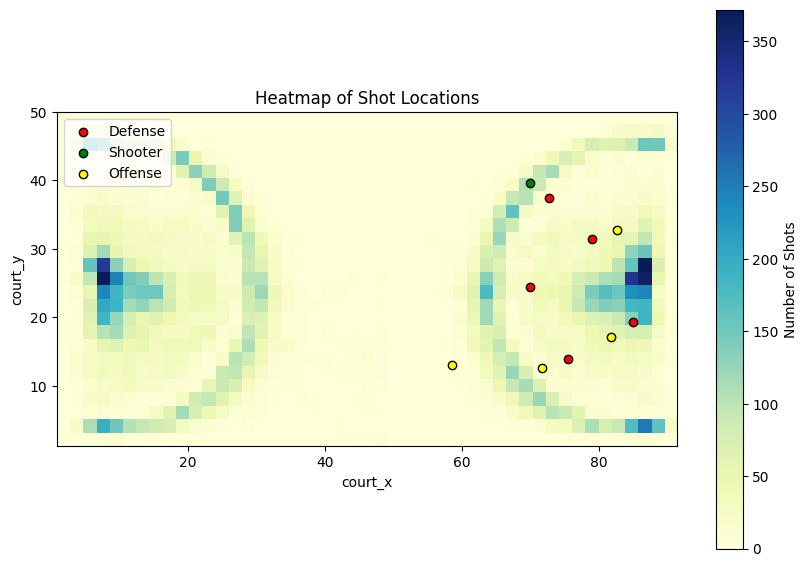

In [17]:
# Define grid size for binning
grid_size = 2

# Use numpy's histogram2d to bin the data
hist, xedges, yedges = np.histogram2d(shooter_data_train['court_x'], shooter_data_train['court_y'], bins=(int(94/grid_size), int(50/grid_size)))

# Plot heatmap
plt.figure(figsize=(10, 7))
plt.imshow(hist.T, origin='lower', cmap='YlGnBu', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Number of Shots')
plt.title('Heatmap of Shot Locations')
plt.xlabel('court_x')
plt.ylabel('court_y')

# Overlay scatter plot of the first play
# red = DEFENSE
defense_first_play = example_floor_oreb.iloc[0:5]
plt.scatter(defense_first_play["court_x"], defense_first_play["court_y"], color='red', label = "Defense", edgecolor='black', zorder=2)

# green = SHOOTER
shooter_first_play = example_floor_oreb.iloc[5:6]
plt.scatter(shooter_first_play["court_x"], shooter_first_play["court_y"], color='green', label = "Shooter", edgecolor='black', zorder=2)

# yellow = OFFENSE
offense_first_play = example_floor_oreb.iloc[6:10]
plt.scatter(offense_first_play["court_x"], offense_first_play["court_y"], color='yellow', label = "Offense", edgecolor='black', zorder=2)

plt.legend(loc='upper left')

plt.show()

# There was NOT an offensive rebound in this play

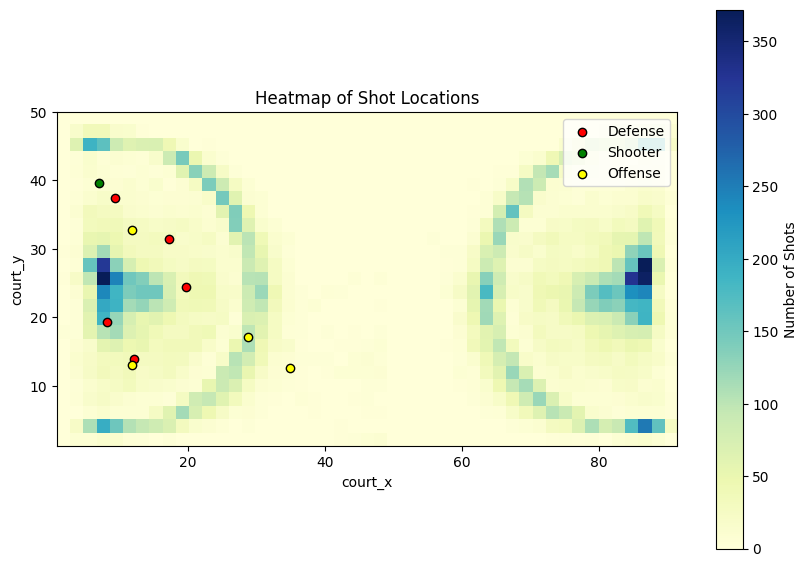

In [18]:
# Define grid size for binning
grid_size = 2

# put the first play with an offensive rebound into "first_oreb_play"
first_oreb_play = example_floor_oreb.iloc[80:90]

# this plot doesnt make a lot of sense with out context, so lets overlay it on the shot heatmap

# Use numpy's histogram2d to bin the data
hist, xedges, yedges = np.histogram2d(shooter_data_train['court_x'], shooter_data_train['court_y'], bins=(int(94/grid_size), int(50/grid_size)))

# Plot heatmap
plt.figure(figsize=(10, 7))
plt.imshow(hist.T, origin='lower', cmap='YlGnBu', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Number of Shots')
plt.title('Heatmap of Shot Locations')
plt.xlabel('court_x')
plt.ylabel('court_y')

# Overlay scatter plot of the first play
# red = DEFENSE
defense_first_oreb_play = first_oreb_play.iloc[0:5]
plt.scatter(defense_first_oreb_play["court_x"], defense_first_play["court_y"], color='red', label = "Defense", edgecolor='black', zorder=2)

# green = SHOOTER
shooter_first_oreb_play = first_oreb_play.iloc[5:6]
plt.scatter(shooter_first_oreb_play["court_x"], shooter_first_play["court_y"], color='green', label = "Shooter", edgecolor='black', zorder=2)

# yellow = OFFENSE
offense_first_oreb_play = first_oreb_play.iloc[6:10]
plt.scatter(offense_first_oreb_play["court_x"], offense_first_play["court_y"], color='yellow', label = "Offense", edgecolor='black', zorder=2)

plt.legend(loc='upper right')

plt.show()

# There was NOT an offensive rebound in this play

### Offensive vs. Defensive Boards Bar Chart

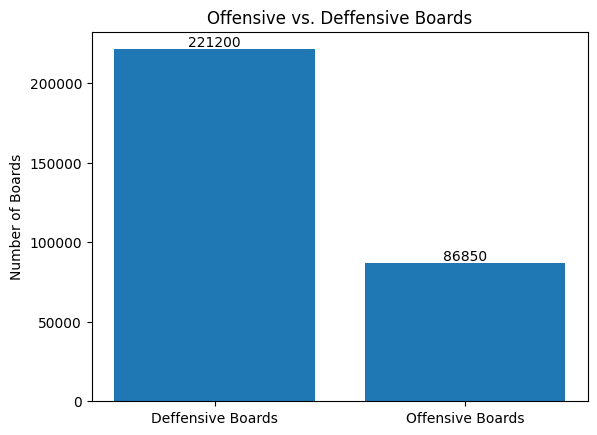

In [19]:
# offensive vs. defensive rebounds

oreb_no_oreb = example_floor_oreb.value_counts("is_oreb")
two = np.array([0,1])

bars = plt.bar(two, oreb_no_oreb)
plt.xticks(range(len(oreb_no_oreb)), ['Deffensive Boards', 'Offensive Boards'])
plt.ylabel('Number of Boards')
plt.title('Offensive vs. Deffensive Boards')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, '%d' % int(height), ha='center', va='bottom')

### Number of Offensive Boards at Each Shot Distance

Text(0.5, 1.0, 'Number of Offensive Boards for each Distance to the Hoop')

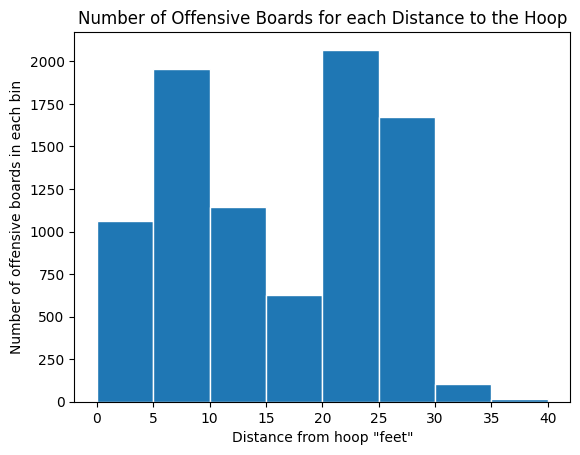

In [20]:
shooter_avg_dist = example_floor_oreb[(example_floor_oreb["is_oreb"] == 1) & (example_floor_oreb['annotation_code'] == 's')]

# hoop at x = 4 is 0, x = 90 is 1
shooter_avg_dist[['shooter_dist_from_hoop', 'which_hoop']] = shooter_avg_dist.apply(calculate_shooter_distance_from_hoop, axis=1)
shooter_avg_dist[['shooter_dist_from_hoop', 'which_hoop']] = shooter_avg_dist.apply(calculate_shooter_distance_from_hoop, axis=1)
# splitting id so that we can group by game
shooter_avg_dist['game_number'] = shooter_avg_dist['id'].str.split('-').str[0]
shooter_avg_dist['play_number'] = shooter_avg_dist['id'].str.split('-').str[1]

bin_edges = np.arange(0,45,5)
plt.hist(shooter_avg_dist['shooter_dist_from_hoop'], bins = bin_edges, edgecolor = "white")
plt.xlabel('Distance from hoop "feet"')
plt.ylabel('Number of offensive boards in each bin')
plt.title('Number of Offensive Boards for each Distance to the Hoop')


Text(0.5, 1.0, 'Number of Offensive Boards for each Distance to the Hoop')

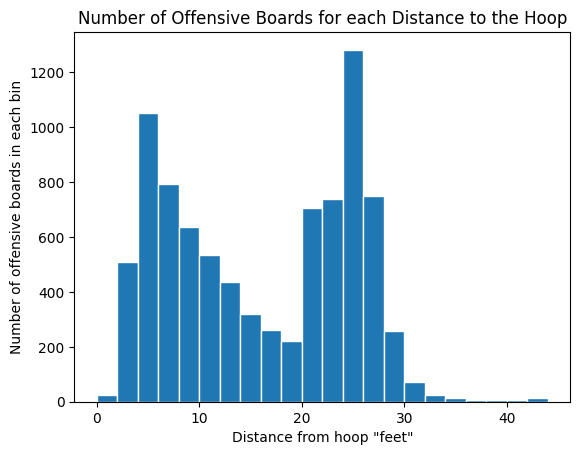

In [21]:
bin_edges = np.arange(0,45,2)
plt.hist(shooter_avg_dist['shooter_dist_from_hoop'], bins = bin_edges, edgecolor = "white")
plt.xlabel('Distance from hoop "feet"')
plt.ylabel('Number of offensive boards in each bin')
plt.title('Number of Offensive Boards for each Distance to the Hoop')

In [22]:
# keep in mind that the three point line is 23.75ft away from 
# the top of the key and 22ft awawy in the corners

### Shot Chart of Shots Where Offensive Boards were Secured

Text(0, 0.5, 'Y coordinates')

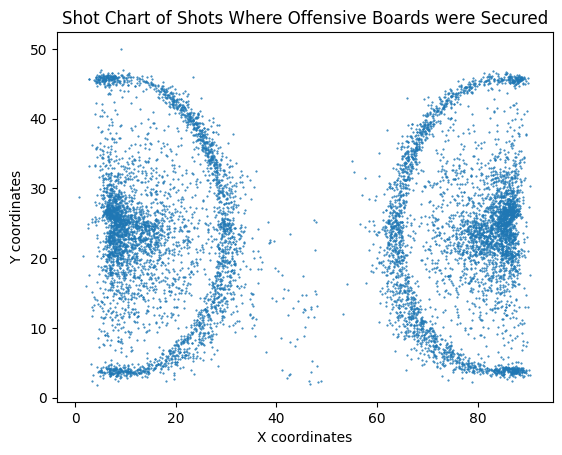

In [23]:
# where shooters are on the court when an offensive board occurs

shooter_oreb_location = example_floor_oreb[(example_floor_oreb["is_oreb"] == 1) & (example_floor_oreb['annotation_code'] == 's')]
shooter_oreb_location 

plt.scatter(shooter_oreb_location['court_x'], shooter_oreb_location['court_y'], marker = '.', s= 1)
plt.title('Shot Chart of Shots Where Offensive Boards were Secured')
plt.xlabel('X coordinates')
plt.ylabel('Y coordinates')

# this is where the shooters are when offensive boards occur
# seems pretty random

### Heatmap of Shots Where Offensive Boards were Secured

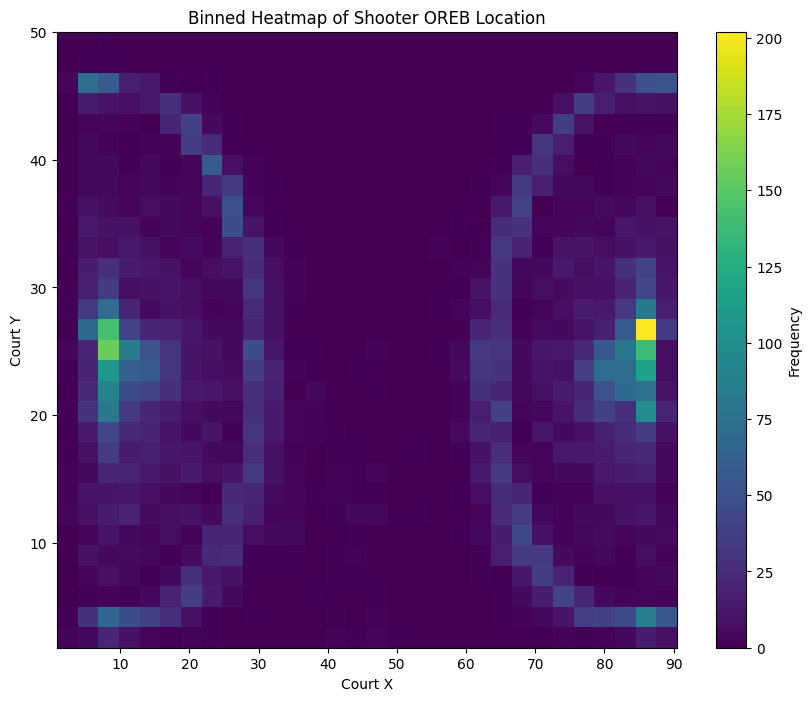

In [24]:
plt.figure(figsize=(10, 8))
plt.hist2d(shooter_oreb_location['court_x'], shooter_oreb_location['court_y'], bins=[30, 30], cmap='viridis')

# Adding color bar for reference
plt.colorbar(label='Frequency')

# Adding labels and title if needed
plt.xlabel('Court X')
plt.ylabel('Court Y')
plt.title('Binned Heatmap of Shooter OREB Location')

# Display the plot
plt.show()

# 2.) Simple Modeling/Baseline Model
- In this section, we will explore an extremely simply logistic regression model that will use two features to predict whether or not a play had an offensive board or not: average distance of the offense from the hoop and the average distance of the defense from the hoop
- This model will be used as a baseline modelt that we can compare our more complex models to

In [25]:
# make a column to denote whether a player is offense, defense, or a shooter
example_floor_oreb['role'] = example_floor_oreb['annotation_code'].apply(lambda x: 'o' if 't' in x else ('d' if 'd' in x else 'o'))
example_floor_oreb

,id,court_x,court_y,annotation_code,is_oreb,team,opponent,conference,opp_conference,role
0,2-2,72.807686,37.409669,d1,0,Kentucky,Duke,SEC,ACC,d
1,2-2,79.080643,31.477796,d2,0,Kentucky,Duke,SEC,ACC,d
2,2-2,69.956321,24.467300,d3,0,Kentucky,Duke,SEC,ACC,d
3,2-2,75.468933,13.861763,d4,0,Kentucky,Duke,SEC,ACC,d
4,2-2,84.973496,19.254422,d5,0,Kentucky,Duke,SEC,ACC,d
...,...,...,...,...,...,...,...,...,...,...
308045,5020-52,70.669644,7.270347,s,0,San Diego St.,Connecticut,MWC,BigEast,o
308046,5020-52,86.958520,4.382292,t1,0,San Diego St.,Connecticut,MWC,BigEast,o
308047,5020-52,58.962087,26.764930,t2,0,San Diego St.,Connecticut,MWC,BigEast,o
308048,5020-52,76.777949,20.427222,t3,0,San Diego St.,Connecticut,MWC,BigEast,o


In [26]:
# add distance from basket for column
example_floor_oreb[['dist_from_hoop', 'which_hoop']] = example_floor_oreb.apply(calculate_shooter_distance_from_hoop, axis=1)
example_floor_oreb

,id,court_x,court_y,annotation_code,is_oreb,team,opponent,conference,opp_conference,role,dist_from_hoop,which_hoop
0,2-2,72.807686,37.409669,d1,0,Kentucky,Duke,SEC,ACC,d,21.203196,1.0
1,2-2,79.080643,31.477796,d2,0,Kentucky,Duke,SEC,ACC,d,12.696228,1.0
2,2-2,69.956321,24.467300,d3,0,Kentucky,Duke,SEC,ACC,d,20.050756,1.0
3,2-2,75.468933,13.861763,d4,0,Kentucky,Duke,SEC,ACC,d,18.308802,1.0
4,2-2,84.973496,19.254422,d5,0,Kentucky,Duke,SEC,ACC,d,7.633964,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
308045,5020-52,70.669644,7.270347,s,0,San Diego St.,Connecticut,MWC,BigEast,o,26.229816,1.0
308046,5020-52,86.958520,4.382292,t1,0,San Diego St.,Connecticut,MWC,BigEast,o,20.840837,1.0
308047,5020-52,58.962087,26.764930,t2,0,San Diego St.,Connecticut,MWC,BigEast,o,31.088053,1.0
308048,5020-52,76.777949,20.427222,t3,0,San Diego St.,Connecticut,MWC,BigEast,o,13.990459,1.0


In [27]:
# function that creates the features
def compute_play_features(play_group):
    play_id = play_group['id'].iloc[0]
    avg_offense_distance = play_group[play_group['role'] == 'o']['dist_from_hoop'].mean()
    avg_defense_distance = play_group[play_group['role'] == 'd']['dist_from_hoop'].mean()
    offensive_rebound = play_group['is_oreb'].max()
    return pd.Series({
        'id': play_id,
        'avg_off_dist': avg_offense_distance,
        'avg_def_dist': avg_defense_distance,
        'is_oreb': offensive_rebound
    })

In [28]:
# make the features
first_model_data = example_floor_oreb.groupby('id').apply(compute_play_features)
first_model_data

#"""
#Keep in mind that in .apply(), axis=1 means the function is applied to each row,
#and axis=0 means that the action is applied to each column.
#"""

# this takes like a minute to run

C:\Users\jacob\AppData\Local\Temp\ipykernel_13464\2305854878.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_model_data = example_floor_oreb.groupby('id').apply(compute_play_features)


,id,avg_off_dist,avg_def_dist,is_oreb
id,,,,
10-10,10-10,19.992596,12.655892,0
10-12,10-12,18.254466,10.024629,0
10-13,10-13,19.422642,13.497611,0
10-3,10-3,18.758507,14.005532,0
10-6,10-6,23.399887,15.824908,0
...,...,...,...,...
998-6,998-6,18.893799,11.202437,0
999-1,999-1,23.120190,14.115630,0
999-3,999-3,18.750908,11.693119,0


In [29]:
# start the actual model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X = first_model_data.iloc[:, 1:3]
y = first_model_data.iloc[:, 3]

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.75, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

# start predicting
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
print('accuracy score: ', accuracy)

classification = classification_report(y_pred, y_test)
print(classification) 

accuracy score:  0.7157881069851987
              precision    recall  f1-score   support

           0       1.00      0.72      0.83      7676
           1       0.01      0.42      0.01        26

    accuracy                           0.72      7702
   macro avg       0.50      0.57      0.42      7702
weighted avg       0.99      0.72      0.83      7702



This model seems like it is doing a good job when in reality it is just predicting all of the non-offensive board plays correctly, and predicting pretty much none of the offensive board plays correctly.

In [30]:
model.coef_

array([[-0.11514249,  0.0519774 ]])

In [31]:
model.intercept_

array([0.5668356])

#### First Model Takeaways

- This model has an accuracy score of 0.716 which is relatively high, but when we take a look at the classification report, we can see that this accuracy score is a bit misleading
- It predicts essentially all of the non-offensive board plays correctly and almost none of the offensive board plays correctly.
- This is because the model is essentially predicting no offensive board for every play.
- **This tells us that average distance of the defense from the hoop and average distance of the offense from the hoop are not great predictors of offensive boards**

# 3.) Feature Engineering

- In this section, we will explore more complex features
- First, we will explore distances of *each player* from the hoop
- This is better than team average distance from the hoop because it will allow us to put more "weight" on players being closer to the hoop.
- We will also explore shot distance from the hoop as another feature

In [32]:
shot_distance_bins = [x for x in range(0, 51, 5)]
zone_labels = [f'{dist}-{dist+5}' for dist in shot_distance_bins[:-1]]
zone_labels[-1] = f'{shot_distance_bins[-2]}+'

# categorize 'shooter_dist_from_hoop' column into corresponding zones
shooter_data_train['shot_distance_zone'] = pd.cut(shooter_data_train['shooter_dist_from_hoop'], bins=shot_distance_bins, labels=zone_labels)
shooter_data_test['shot_distance_zone'] = pd.cut(shooter_data_test['shooter_dist_from_hoop'], bins=shot_distance_bins, labels=zone_labels)

# perform One-Hot Encoding for the 'shot_distance_zone' column
df_encoded_3bins_train = pd.get_dummies(shooter_data_train, columns=['shot_distance_zone'])
df_encoded_3bins_test = pd.get_dummies(shooter_data_test, columns=['shot_distance_zone'])

In [33]:
df_encoded_3bins_train

,id,court_x,court_y,annotation_code,offense,shooter,shooter_dist_from_hoop,which_hoop,game_number,play_number,shot_distance_zone_0-5,shot_distance_zone_5-10,shot_distance_zone_10-15,shot_distance_zone_15-20,shot_distance_zone_20-25,shot_distance_zone_25-30,shot_distance_zone_30-35,shot_distance_zone_35-40,shot_distance_zone_40-45,shot_distance_zone_45+
5,2-2,69.994331,39.674616,s,1,1,24.810706,1.0,2,2,False,False,False,False,True,False,False,False,False,False
15,2-3,16.896578,13.154704,s,1,1,17.510933,0.0,2,3,False,False,False,True,False,False,False,False,False,False
25,2-4,87.963438,3.638889,s,1,1,21.457974,1.0,2,4,False,False,False,False,True,False,False,False,False,False
35,2-6,80.185287,22.850748,s,1,1,10.047281,1.0,2,6,False,False,True,False,False,False,False,False,False,False
45,2-8,70.659638,39.791936,s,1,1,24.348532,1.0,2,8,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308005,5020-46,75.406582,43.315000,s,1,1,23.418093,1.0,5020,46,False,False,False,False,True,False,False,False,False,False
308015,5020-47,34.976740,28.423749,s,1,1,31.165373,0.0,5020,47,False,False,False,False,False,False,True,False,False,False
308025,5020-48,12.023261,24.935416,s,1,1,8.023521,0.0,5020,48,False,True,False,False,False,False,False,False,False,False
308035,5020-49,63.025313,12.659930,s,1,1,29.663295,1.0,5020,49,False,False,False,False,False,True,False,False,False,False


In [34]:
def calculate_distance_from_hoop(row):
    # define the coordinates of the hoop
    hoop_coordinates = np.array([[4.0, 25.0], [90.0, 25.0]]) 
    def_coordinates = np.array([row['court_x'], row['court_y']])
    
    # calculate the distance
    distance = np.linalg.norm(def_coordinates - hoop_coordinates[int(row['which_hoop'])])
    return distance

In [35]:
zone_labels

['0-5',
 '5-10',
 '10-15',
 '15-20',
 '20-25',
 '25-30',
 '30-35',
 '35-40',
 '40-45',
 '45+']

In [36]:
# merging the information we have learned about which hoop is being shot at back to the training set
training_data = training_data.merge(shooter_data_train[['id', 'which_hoop']], left_on='id', right_on='id')
testing_data = testing_data.merge(shooter_data_test[['id', 'which_hoop']], left_on='id', right_on='id')

In [37]:
training_data

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop
0,2-2,72.807686,37.409669,d1,0,0,1.0
1,2-2,79.080643,31.477796,d2,0,0,1.0
2,2-2,69.956321,24.467300,d3,0,0,1.0
3,2-2,75.468933,13.861763,d4,0,0,1.0
4,2-2,84.973496,19.254422,d5,0,0,1.0
...,...,...,...,...,...,...,...
308045,5020-52,70.669644,7.270347,s,1,1,1.0
308046,5020-52,86.958520,4.382292,t1,1,0,1.0
308047,5020-52,58.962087,26.764930,t2,1,0,1.0
308048,5020-52,76.777949,20.427222,t3,1,0,1.0


In [38]:
def process_defender_distances(df, offense):
    """
    Processes the input dataframe for players, calculates their distances from the hoop,
    ranks them by distance, and pivots the data to create features for the closest 
    players to the hoop.
    
    Parameters:
    - df (pandas.DataFrame): Input dataframe with player data.
    - offense (int): 1 for offense 0 for defense.
    
    Returns:
    - pandas.DataFrame: Processed dataframe with ranked distances.
    """
    
    # this line filters the input DataFrame to include only rows 
    # where the offense column matches the offense parameter. 
    # It creates a copy of this filtered DataFrame called distance.
    distance = df.loc[df.offense == offense].copy()
    
    # This sets the prefix variable to 'off' for offensive players and 'def' for defensive players.
    prefix = 'off' if offense == 1 else 'def'

    # calculate player distance from hoop
    distance[f'{prefix}_distance'] = distance.apply(calculate_distance_from_hoop, axis=1)
    
    # rank the players within each play (id) by distance from the hoop
    distance['rank'] = distance.groupby('id')[f'{prefix}_distance'].rank(method='first')

    # calculating mean distance from the hoop; groupby will resort by id the same way the rank calc does
    mean_dists = distance.groupby('id')[f'{prefix}_distance'].mean()
    
    # pivot the DataFrame to get features for closest_def_to_hoop, second_closest_def_to_hoop, and so on
    df_pivot = distance.pivot_table(index='id', columns='rank', values=f'{prefix}_distance').add_prefix(prefix + '_').reset_index()
    
    # rename the columns to be more descriptive
    df_pivot.columns = ['id'] + [f'closest_{prefix}_to_hoop', f'second_closest_{prefix}_to_hoop', f'third_closest_{prefix}_to_hoop', f'fourth_closest_{prefix}_to_hoop', f'fifth_closest_{prefix}_to_hoop']
    
    # fill missing values (if any) with a specific value, e.g., -1
    df_pivot.fillna(-1, inplace=True)

    # inserting mean values as a column
    df_pivot[f'{prefix}_distance_mean'] = mean_dists.values
    
    return df_pivot

In [39]:
# Pivots the data so there is one row per play
def_pivot = process_defender_distances(training_data, 0)
off_pivot = process_defender_distances(training_data, 1)
def_pivot_test = process_defender_distances(testing_data, 0)
off_pivot_test = process_defender_distances(testing_data, 1)

In [40]:
off_pivot

,id,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop,off_distance_mean
0,10-10,10.328278,15.046402,23.173309,25.311266,26.103727,19.992596
1,10-12,4.132574,17.754600,20.971792,23.246796,25.166567,18.254466
2,10-13,8.968685,17.949111,21.778384,23.195872,25.221159,19.422642
3,10-3,7.958549,13.436814,22.160137,24.473980,25.763053,18.758507
4,10-6,17.564172,21.746126,24.109830,25.010259,28.569046,23.399887
...,...,...,...,...,...,...,...
30800,998-6,7.439119,9.779038,22.979599,25.934914,28.336323,18.893799
30801,999-1,16.251397,20.797153,23.278141,27.605668,27.668590,23.120190
30802,999-3,4.185496,10.309801,23.648947,26.127283,29.483015,18.750908
30803,999-4,6.409752,13.723681,23.322406,27.534543,29.838589,20.165794


In [41]:
# combining the player distance dataframe on play id
pivot_train = def_pivot.merge(off_pivot, on='id')
pivot_test = def_pivot_test.merge(off_pivot_test, on='id')
pivot_train = pivot_train.merge(train_pbp[['id', 'is_oreb']], on='id')

In [42]:
pivot_train

,id,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,def_distance_mean,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop,off_distance_mean,is_oreb
0,10-10,9.272356,10.056615,12.992872,14.782542,16.175073,12.655892,10.328278,15.046402,23.173309,25.311266,26.103727,19.992596,0
1,10-12,3.087682,4.322785,10.780686,15.429233,16.502760,10.024629,4.132574,17.754600,20.971792,23.246796,25.166567,18.254466,0
2,10-13,5.753939,12.180877,12.535084,14.027878,22.990277,13.497611,8.968685,17.949111,21.778384,23.195872,25.221159,19.422642,0
3,10-3,5.824702,10.965734,13.980346,17.154582,22.102294,14.005532,7.958549,13.436814,22.160137,24.473980,25.763053,18.758507,0
4,10-6,7.887358,11.555978,11.713705,17.826780,30.140720,15.824908,17.564172,21.746126,24.109830,25.010259,28.569046,23.399887,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30800,998-6,5.051764,5.698795,10.409649,16.441614,18.410362,11.202437,7.439119,9.779038,22.979599,25.934914,28.336323,18.893799,0
30801,999-1,6.871711,9.045484,16.700200,18.153897,19.806861,14.115630,16.251397,20.797153,23.278141,27.605668,27.668590,23.120190,0
30802,999-3,6.221014,8.305409,13.068824,15.167463,15.702884,11.693119,4.185496,10.309801,23.648947,26.127283,29.483015,18.750908,0
30803,999-4,3.624681,6.639501,18.337839,20.509509,22.498832,14.322072,6.409752,13.723681,23.322406,27.534543,29.838589,20.165794,0


Text(0.5, 1.0, 'Average Distance of Closest Offensive and Defensive Players from the Hoop')

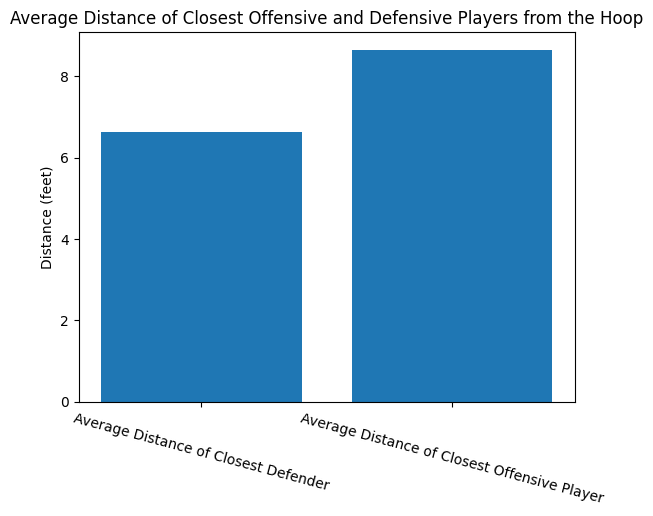

In [43]:
closest_def_dist_mean = pivot_train['closest_def_to_hoop'].mean()
closest_off_dist_mean = pivot_train['closest_off_to_hoop'].mean()
height = [closest_def_dist_mean, closest_off_dist_mean]
x = ['Average Distance of Closest Defender', 'Average Distance of Closest Offensive Player']

plt.bar(x, height)
plt.xticks(rotation=-15)
plt.ylabel('Distance (feet)')
plt.title('Average Distance of Closest Offensive and Defensive Players from the Hoop')

#### Average Distance of Closest Offensive and Defensive Players from the Hoop Bar Chart Takeaways
- The closest player is usually a defensive player
- This is why most boards are defensive players

Text(0.5, 1.0, 'Average Distance of Offense and Defense from Hoop')

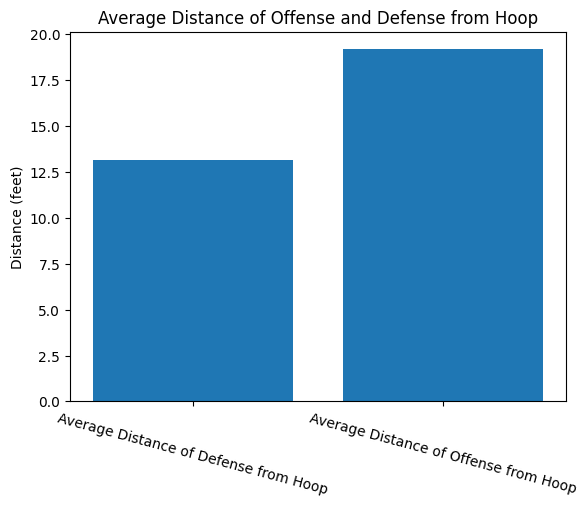

In [44]:
def_dist_mean = pivot_train['def_distance_mean'].mean()
off_dist_mean = pivot_train['off_distance_mean'].mean()
height = [def_dist_mean, off_dist_mean]
x = ['Average Distance of Defense from Hoop', 'Average Distance of Offense from Hoop']

plt.bar(x, height)
plt.xticks(rotation=-15)
plt.ylabel('Distance (feet)')
plt.title('Average Distance of Offense and Defense from Hoop')

#### Average Distance of Offense and Defense from Hoop Bar Chart Takeaways
- The offense is usually much farther from the hoop than the defense
- This makes sense as we saw from before that most of the boards go to the defense
- This validates that distance from the hoop is a valid feature

In [45]:
# create a dataframe that gives just play id and shot distances
shooter_distances = df_encoded_3bins_train.iloc[:, [0]+ list(range(10,20))]
shooter_distances

,id,shot_distance_zone_0-5,shot_distance_zone_5-10,shot_distance_zone_10-15,shot_distance_zone_15-20,shot_distance_zone_20-25,shot_distance_zone_25-30,shot_distance_zone_30-35,shot_distance_zone_35-40,shot_distance_zone_40-45,shot_distance_zone_45+
5,2-2,False,False,False,False,True,False,False,False,False,False
15,2-3,False,False,False,True,False,False,False,False,False,False
25,2-4,False,False,False,False,True,False,False,False,False,False
35,2-6,False,False,True,False,False,False,False,False,False,False
45,2-8,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
308005,5020-46,False,False,False,False,True,False,False,False,False,False
308015,5020-47,False,False,False,False,False,False,True,False,False,False
308025,5020-48,False,True,False,False,False,False,False,False,False,False
308035,5020-49,False,False,False,False,False,True,False,False,False,False


In [46]:
# merge the shot distances data frame and the closest player dataframes

model1_features = pd.merge(pivot_train, shooter_distances, on='id', how = 'right')
model1_features

,id,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,def_distance_mean,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,...,shot_distance_zone_0-5,shot_distance_zone_5-10,shot_distance_zone_10-15,shot_distance_zone_15-20,shot_distance_zone_20-25,shot_distance_zone_25-30,shot_distance_zone_30-35,shot_distance_zone_35-40,shot_distance_zone_40-45,shot_distance_zone_45+
0,2-2,7.633964,12.696228,18.308802,20.050756,21.203196,15.978589,10.641781,11.430082,22.130707,...,False,False,False,False,True,False,False,False,False,False
1,2-3,6.951207,8.954561,13.582648,15.019406,15.342599,11.970084,17.510933,20.646002,20.747640,...,False,False,False,True,False,False,False,False,False,False
2,2-4,7.585616,8.649579,17.621429,25.116109,27.285472,17.251641,5.814472,21.457974,24.860005,...,False,False,False,False,True,False,False,False,False,False
3,2-6,6.140183,7.291817,8.300214,14.131598,15.292797,10.231322,10.047281,22.132454,23.110874,...,False,False,True,False,False,False,False,False,False,False
4,2-8,12.897550,13.705211,20.071723,20.182427,25.681385,18.507660,20.512189,21.590307,24.348532,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30800,5020-46,5.655688,17.025468,18.118633,18.357469,19.731694,15.777790,8.830529,19.281527,20.708691,...,False,False,False,False,True,False,False,False,False,False
30801,5020-47,7.200086,7.592854,15.012815,20.322350,25.956997,15.217020,13.321681,20.627279,21.207575,...,False,False,False,False,False,False,True,False,False,False
30802,5020-48,5.961899,11.343778,14.310515,14.553908,34.339084,16.101837,8.023521,12.947685,15.704342,...,False,True,False,False,False,False,False,False,False,False
30803,5020-49,12.243245,12.873617,13.942461,18.613618,22.748294,16.084247,19.649618,21.416060,22.502382,...,False,False,False,False,False,True,False,False,False,False


In [47]:
# make sure there are no NaNs before machine learning model
model1_features.isna().sum()

id                            0
closest_def_to_hoop           0
second_closest_def_to_hoop    0
third_closest_def_to_hoop     0
fourth_closest_def_to_hoop    0
fifth_closest_def_to_hoop     0
def_distance_mean             0
closest_off_to_hoop           0
second_closest_off_to_hoop    0
third_closest_off_to_hoop     0
fourth_closest_off_to_hoop    0
fifth_closest_off_to_hoop     0
off_distance_mean             0
is_oreb                       0
shot_distance_zone_0-5        0
shot_distance_zone_5-10       0
shot_distance_zone_10-15      0
shot_distance_zone_15-20      0
shot_distance_zone_20-25      0
shot_distance_zone_25-30      0
shot_distance_zone_30-35      0
shot_distance_zone_35-40      0
shot_distance_zone_40-45      0
shot_distance_zone_45+        0
dtype: int64

### Feature Engineering Continued
- We know that our current features are doing a decent job of predicting offensive boards but we can do better
- In this section, we will continue to feature engineer - we will now take team into account 

In [48]:
# Make the team offensive board possession feature
# group by team and find the offensive rebounding mean
a = train_pbp.groupby('team')['is_oreb'].mean() 

# get df with play id, team, and opposing team for merging
team = train_pbp.loc[:, ['id', 'team', 'opponent']]
team

,id,team,opponent
0,2-2,Kentucky,Duke
1,2-3,Duke,Kentucky
2,2-4,Kentucky,Duke
3,2-6,Kentucky,Duke
4,2-8,Kentucky,Duke
...,...,...,...
30800,5020-46,San Diego St.,Connecticut
30801,5020-47,Connecticut,San Diego St.
30802,5020-48,Connecticut,San Diego St.
30803,5020-49,San Diego St.,Connecticut


In [49]:
# merge to add team and opposing team to the features df

model1_features_with_team = pd.merge(model1_features, team, on = 'id')
model1_features_with_team

,id,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,def_distance_mean,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,...,shot_distance_zone_10-15,shot_distance_zone_15-20,shot_distance_zone_20-25,shot_distance_zone_25-30,shot_distance_zone_30-35,shot_distance_zone_35-40,shot_distance_zone_40-45,shot_distance_zone_45+,team,opponent
0,2-2,7.633964,12.696228,18.308802,20.050756,21.203196,15.978589,10.641781,11.430082,22.130707,...,False,False,True,False,False,False,False,False,Kentucky,Duke
1,2-3,6.951207,8.954561,13.582648,15.019406,15.342599,11.970084,17.510933,20.646002,20.747640,...,False,True,False,False,False,False,False,False,Duke,Kentucky
2,2-4,7.585616,8.649579,17.621429,25.116109,27.285472,17.251641,5.814472,21.457974,24.860005,...,False,False,True,False,False,False,False,False,Kentucky,Duke
3,2-6,6.140183,7.291817,8.300214,14.131598,15.292797,10.231322,10.047281,22.132454,23.110874,...,True,False,False,False,False,False,False,False,Kentucky,Duke
4,2-8,12.897550,13.705211,20.071723,20.182427,25.681385,18.507660,20.512189,21.590307,24.348532,...,False,False,True,False,False,False,False,False,Kentucky,Duke
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30800,5020-46,5.655688,17.025468,18.118633,18.357469,19.731694,15.777790,8.830529,19.281527,20.708691,...,False,False,True,False,False,False,False,False,San Diego St.,Connecticut
30801,5020-47,7.200086,7.592854,15.012815,20.322350,25.956997,15.217020,13.321681,20.627279,21.207575,...,False,False,False,False,True,False,False,False,Connecticut,San Diego St.
30802,5020-48,5.961899,11.343778,14.310515,14.553908,34.339084,16.101837,8.023521,12.947685,15.704342,...,False,False,False,False,False,False,False,False,Connecticut,San Diego St.
30803,5020-49,12.243245,12.873617,13.942461,18.613618,22.748294,16.084247,19.649618,21.416060,22.502382,...,False,False,False,True,False,False,False,False,San Diego St.,Connecticut


In [50]:
# merge and add rebound percentages to features df

model1_features_with_team_oreb = pd.merge(model1_features_with_team, a, on = 'team')
model1_features_with_team_oreb.rename(columns={'is_oreb_y':'team_oreb_percentage'}, inplace = True)

model1_features_with_team_oreb = pd.merge(model1_features_with_team_oreb, a, left_on = 'opponent', right_on = 'team')
model1_features_with_team_oreb.rename(columns={'is_oreb':'opp_oreb_percentage'}, inplace = True)
model1_features_with_team_oreb.rename(columns={'is_oreb_x':'is_oreb'}, inplace = True)

model1_features_with_team_oreb

,id,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,def_distance_mean,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,...,shot_distance_zone_20-25,shot_distance_zone_25-30,shot_distance_zone_30-35,shot_distance_zone_35-40,shot_distance_zone_40-45,shot_distance_zone_45+,team,opponent,team_oreb_percentage,opp_oreb_percentage
0,2-2,7.633964,12.696228,18.308802,20.050756,21.203196,15.978589,10.641781,11.430082,22.130707,...,True,False,False,False,False,False,Kentucky,Duke,0.318795,0.316341
1,2-3,6.951207,8.954561,13.582648,15.019406,15.342599,11.970084,17.510933,20.646002,20.747640,...,False,False,False,False,False,False,Duke,Kentucky,0.316341,0.318795
2,2-4,7.585616,8.649579,17.621429,25.116109,27.285472,17.251641,5.814472,21.457974,24.860005,...,True,False,False,False,False,False,Kentucky,Duke,0.318795,0.316341
3,2-6,6.140183,7.291817,8.300214,14.131598,15.292797,10.231322,10.047281,22.132454,23.110874,...,False,False,False,False,False,False,Kentucky,Duke,0.318795,0.316341
4,2-8,12.897550,13.705211,20.071723,20.182427,25.681385,18.507660,20.512189,21.590307,24.348532,...,True,False,False,False,False,False,Kentucky,Duke,0.318795,0.316341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26651,5020-46,5.655688,17.025468,18.118633,18.357469,19.731694,15.777790,8.830529,19.281527,20.708691,...,True,False,False,False,False,False,San Diego St.,Connecticut,0.300752,0.348066
26652,5020-47,7.200086,7.592854,15.012815,20.322350,25.956997,15.217020,13.321681,20.627279,21.207575,...,False,False,True,False,False,False,Connecticut,San Diego St.,0.348066,0.300752
26653,5020-48,5.961899,11.343778,14.310515,14.553908,34.339084,16.101837,8.023521,12.947685,15.704342,...,False,False,False,False,False,False,Connecticut,San Diego St.,0.348066,0.300752
26654,5020-49,12.243245,12.873617,13.942461,18.613618,22.748294,16.084247,19.649618,21.416060,22.502382,...,False,True,False,False,False,False,San Diego St.,Connecticut,0.300752,0.348066


Text(0.5, 0, '')

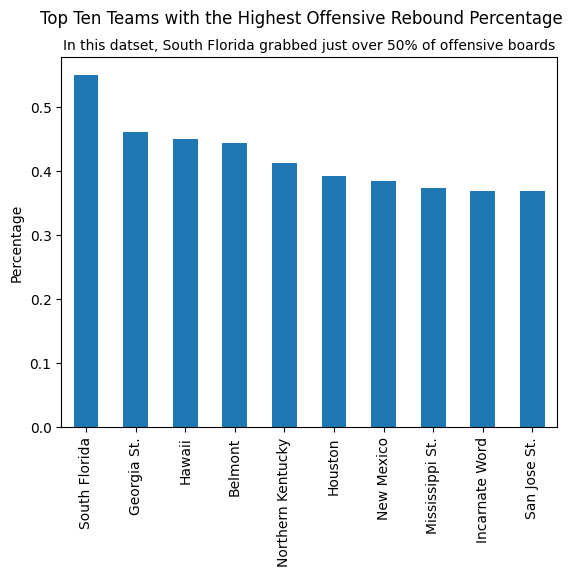

In [51]:
top_10_oreb_teams = a.sort_values(ascending=False).iloc[:10]

top_10_oreb_teams.plot(kind='bar')
plt.suptitle('Top Ten Teams with the Highest Offensive Rebound Percentage')
plt.title('In this datset, South Florida grabbed just over 50% of offensive boards', fontsize = 10)
plt.ylabel('Percentage')
plt.xlabel('')

In [52]:
# model with these extra features

desired_columns = list(range(1, 13)) + list(range(14, 24)) + list(range(26,28))
X = model1_features_with_team_oreb.iloc[:, desired_columns]
y = model1_features_with_team_oreb.iloc[:, 13]

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.75, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit model
model = GaussianNB()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_pred, y_test)
print('Accuracy score:', accuracy)

classification = classification_report(y_pred, y_test)
print(classification) 

# marginal increase

Accuracy score: 0.6421068427370948
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      4753
           1       0.37      0.36      0.37      1911

    accuracy                           0.64      6664
   macro avg       0.56      0.56      0.56      6664
weighted avg       0.64      0.64      0.64      6664



#### New Features Takeaways
- Adding these new features (team offensive rebound percentage) increased the accuracy very marginally
- It is worth keeping, but did not make a super signfiicant change

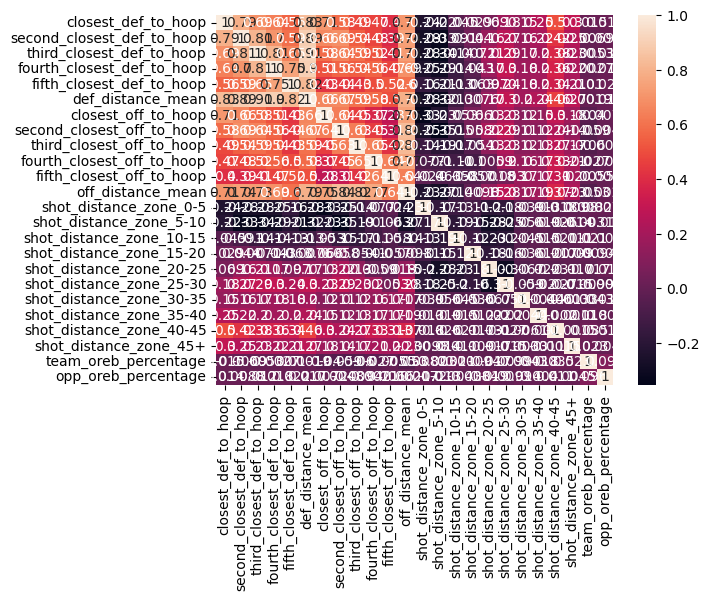

<Figure size 4000x3200 with 0 Axes>

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True)
plt.figure(figsize=(40, 32))
plt.show()

# 4.) More Complex Feature Engineering
- In this section, we add another feature - distance of the closest defender to each offensive player.
    - This feature will help predict offensive boards because typically, the closer a defensive player is to an offensive player, the less likely they are to grab an offensive board
- Additionally, I will also add zoning features.
    - The intuition behind this is the fact that offensive boards are more prone to happen on the opposite side of the court of the shooter
    - If the shooter is in the right wing, then the offensive board will mostly likley happen in the left wing.
    - This means creating a feature that counts the amount of people in the opposite zone of the shooter will help us predict offensive rebounds.

### Distance of the cloesest defender feature

In [54]:
# Make a copy of the dataset

closest_player = example_floor_oreb
closest_player.head(10)

,id,court_x,court_y,annotation_code,is_oreb,team,opponent,conference,opp_conference,role,dist_from_hoop,which_hoop
0,2-2,72.807686,37.409669,d1,0,Kentucky,Duke,SEC,ACC,d,21.203196,1.0
1,2-2,79.080643,31.477796,d2,0,Kentucky,Duke,SEC,ACC,d,12.696228,1.0
2,2-2,69.956321,24.467300,d3,0,Kentucky,Duke,SEC,ACC,d,20.050756,1.0
3,2-2,75.468933,13.861763,d4,0,Kentucky,Duke,SEC,ACC,d,18.308802,1.0
4,2-2,84.973496,19.254422,d5,0,Kentucky,Duke,SEC,ACC,d,7.633964,1.0
5,2-2,69.994331,39.674616,s,0,Kentucky,Duke,SEC,ACC,o,24.810706,1.0
6,2-2,82.692421,32.736070,t1,0,Kentucky,Duke,SEC,ACC,o,10.641781,1.0
7,2-2,81.741959,17.097372,t2,0,Kentucky,Duke,SEC,ACC,o,11.430082,1.0
8,2-2,71.667114,12.603488,t3,0,Kentucky,Duke,SEC,ACC,o,22.130707,1.0
9,2-2,58.550842,12.962986,t4,0,Kentucky,Duke,SEC,ACC,o,33.674014,1.0


In [55]:
# Calculate the distance of each offenisve player to each defensive player within each play group

def calculate_distances_within_group(group):
    offensive_players = group[group['role'] == 'o'].reset_index(drop=True)
    defensive_players = group[group['role'] == 'd'].reset_index(drop=True)
    
    for i, off_player in offensive_players.iterrows():
        for j, def_player in defensive_players.iterrows():
            col_name = f'dist_off_{off_player["annotation_code"]}_def_{def_player["annotation_code"]}'
            distance = np.sqrt((off_player['court_x'] - def_player['court_x'])**2 + (off_player['court_y'] - def_player['court_y'])**2)
            group[col_name] = distance
            
    return group

# Apply the function to each group
df = closest_player.groupby('id').apply(calculate_distances_within_group)

# this cell takes around 5 minutes to run

C:\Users\jacob\AppData\Local\Temp\ipykernel_13464\2044234965.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = closest_player.groupby('id').apply(calculate_distances_within_group)


In [56]:
df.columns

Index(['id', 'court_x', 'court_y', 'annotation_code', 'is_oreb', 'team',
       'opponent', 'conference', 'opp_conference', 'role', 'dist_from_hoop',
       'which_hoop', 'dist_off_s_def_d1', 'dist_off_s_def_d2',
       'dist_off_s_def_d3', 'dist_off_s_def_d4', 'dist_off_s_def_d5',
       'dist_off_t1_def_d1', 'dist_off_t1_def_d2', 'dist_off_t1_def_d3',
       'dist_off_t1_def_d4', 'dist_off_t1_def_d5', 'dist_off_t2_def_d1',
       'dist_off_t2_def_d2', 'dist_off_t2_def_d3', 'dist_off_t2_def_d4',
       'dist_off_t2_def_d5', 'dist_off_t3_def_d1', 'dist_off_t3_def_d2',
       'dist_off_t3_def_d3', 'dist_off_t3_def_d4', 'dist_off_t3_def_d5',
       'dist_off_t4_def_d1', 'dist_off_t4_def_d2', 'dist_off_t4_def_d3',
       'dist_off_t4_def_d4', 'dist_off_t4_def_d5'],
      dtype='object')

In [57]:
# make sure function worked

df_dropped = df.droplevel(level=0)
df_dropped

,id,court_x,court_y,annotation_code,is_oreb,team,opponent,conference,opp_conference,role,...,dist_off_t3_def_d1,dist_off_t3_def_d2,dist_off_t3_def_d3,dist_off_t3_def_d4,dist_off_t3_def_d5,dist_off_t4_def_d1,dist_off_t4_def_d2,dist_off_t4_def_d3,dist_off_t4_def_d4,dist_off_t4_def_d5
360,10-10,16.757017,22.535605,d1,0,Duke,Army,ACC,Patriot League,d,...,11.289241,11.403986,10.438975,2.025524,4.747020,20.812772,18.098620,21.555268,14.537433,8.397764
361,10-10,20.172220,25.303751,d2,0,Duke,Army,ACC,Patriot League,d,...,11.289241,11.403986,10.438975,2.025524,4.747020,20.812772,18.098620,21.555268,14.537433,8.397764
362,10-10,13.667048,22.228054,d3,0,Duke,Army,ACC,Patriot League,d,...,11.289241,11.403986,10.438975,2.025524,4.747020,20.812772,18.098620,21.555268,14.537433,8.397764
363,10-10,11.552852,30.378756,d4,0,Duke,Army,ACC,Patriot League,d,...,11.289241,11.403986,10.438975,2.025524,4.747020,20.812772,18.098620,21.555268,14.537433,8.397764
364,10-10,12.853857,36.837769,d5,0,Duke,Army,ACC,Patriot League,d,...,11.289241,11.403986,10.438975,2.025524,4.747020,20.812772,18.098620,21.555268,14.537433,8.397764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40825,999-5,89.955131,45.804170,s,0,St. John's,DePaul,BigEast,BigEast,o,...,28.590202,25.890620,17.705274,8.285328,13.382988,35.157558,31.816307,27.994145,17.753263,16.007344
40826,999-5,70.668906,39.104168,t1,0,St. John's,DePaul,BigEast,BigEast,o,...,28.590202,25.890620,17.705274,8.285328,13.382988,35.157558,31.816307,27.994145,17.753263,16.007344
40827,999-5,84.431093,25.006945,t2,0,St. John's,DePaul,BigEast,BigEast,o,...,28.590202,25.890620,17.705274,8.285328,13.382988,35.157558,31.816307,27.994145,17.753263,16.007344
40828,999-5,68.482551,18.500774,t3,0,St. John's,DePaul,BigEast,BigEast,o,...,28.590202,25.890620,17.705274,8.285328,13.382988,35.157558,31.816307,27.994145,17.753263,16.007344


In [58]:
# Only keep the columns with the closest distance for each player

distance_columns = [col for col in df.columns if col.startswith('dist_off_')]

# Find the closest defender for each offensive player
for role in ['s', 't1', 't2', 't3', 't4']:
    role_columns = [col for col in distance_columns if f'dist_off_{role}' in col]
    if role_columns:
        df[f'closest_defender_dist_{role}'] = df[role_columns].min(axis=1)

# Keep only the necessary columns
columns_to_keep = ['id', 'court_x', 'court_y', 'annotation_code', 'role', 'team', 'opponent', 'conference', 'opp_conference', 'is_oreb', 'dist_from_hoop', 'which_hoop']
for role in ['s', 't1', 't2', 't3', 't4']:
    columns_to_keep.append(f'closest_defender_dist_{role}')

df_filtered = df[columns_to_keep]

In [59]:
# make sure it worked

closest_player = df_filtered.droplevel(level=0)
closest_player

,id,court_x,court_y,annotation_code,role,team,opponent,conference,opp_conference,is_oreb,dist_from_hoop,which_hoop,closest_defender_dist_s,closest_defender_dist_t1,closest_defender_dist_t2,closest_defender_dist_t3,closest_defender_dist_t4
360,10-10,16.757017,22.535605,d1,d,Duke,Army,ACC,Patriot League,0,12.992872,0.0,13.789984,2.261813,10.578670,2.025524,8.397764
361,10-10,20.172220,25.303751,d2,d,Duke,Army,ACC,Patriot League,0,16.175073,0.0,13.789984,2.261813,10.578670,2.025524,8.397764
362,10-10,13.667048,22.228054,d3,d,Duke,Army,ACC,Patriot League,0,10.056615,0.0,13.789984,2.261813,10.578670,2.025524,8.397764
363,10-10,11.552852,30.378756,d4,d,Duke,Army,ACC,Patriot League,0,9.272356,0.0,13.789984,2.261813,10.578670,2.025524,8.397764
364,10-10,12.853857,36.837769,d5,d,Duke,Army,ACC,Patriot League,0,14.782542,0.0,13.789984,2.261813,10.578670,2.025524,8.397764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40825,999-5,89.955131,45.804170,s,o,St. John's,DePaul,BigEast,BigEast,0,20.804219,1.0,6.421389,4.950456,4.519642,8.285328,16.007344
40826,999-5,70.668906,39.104168,t1,o,St. John's,DePaul,BigEast,BigEast,0,23.929454,1.0,6.421389,4.950456,4.519642,8.285328,16.007344
40827,999-5,84.431093,25.006945,t2,o,St. John's,DePaul,BigEast,BigEast,0,5.568911,1.0,6.421389,4.950456,4.519642,8.285328,16.007344
40828,999-5,68.482551,18.500774,t3,o,St. John's,DePaul,BigEast,BigEast,0,22.477556,1.0,6.421389,4.950456,4.519642,8.285328,16.007344


In [60]:
# Create new model features

columns = [0,12,13,14,15,16]

closest_player_features = closest_player.iloc[:, columns]
closest_player_features = closest_player_features.groupby('id').mean()
closest_player_features = closest_player_features.reset_index()
closest_player_features

,id,closest_defender_dist_s,closest_defender_dist_t1,closest_defender_dist_t2,closest_defender_dist_t3,closest_defender_dist_t4
0,10-10,13.789984,2.261813,10.578670,2.025524,8.397764
1,10-12,1.880121,9.203814,7.817852,8.744086,11.539327
2,10-13,5.963871,8.960628,7.005270,3.843466,12.608226
3,10-3,2.436148,3.122470,11.000181,6.160975,9.879494
4,10-6,6.288926,14.394144,15.321889,13.298008,12.870206
...,...,...,...,...,...,...
30800,998-6,2.630615,9.692061,4.141381,7.702545,10.371496
30801,999-1,5.945233,13.439517,7.874263,5.010482,11.069616
30802,999-3,4.245269,5.753795,11.661778,14.447466,11.251099
30803,999-4,2.860249,7.672762,13.980320,8.785412,9.329941


In [61]:
new_model_features = pd.merge(model1_features_with_team_oreb, closest_player_features, on='id')
new_model_features

,id,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,def_distance_mean,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,...,shot_distance_zone_45+,team,opponent,team_oreb_percentage,opp_oreb_percentage,closest_defender_dist_s,closest_defender_dist_t1,closest_defender_dist_t2,closest_defender_dist_t3,closest_defender_dist_t4
0,2-2,7.633964,12.696228,18.308802,20.050756,21.203196,15.978589,10.641781,11.430082,22.130707,...,False,Kentucky,Duke,0.318795,0.316341,3.611780,3.824682,3.885318,4.004633,16.199820
1,2-3,6.951207,8.954561,13.582648,15.019406,15.342599,11.970084,17.510933,20.646002,20.747640,...,False,Duke,Kentucky,0.316341,0.318795,2.308926,8.766549,11.931643,13.445518,16.762972
2,2-4,7.585616,8.649579,17.621429,25.116109,27.285472,17.251641,5.814472,21.457974,24.860005,...,False,Kentucky,Duke,0.318795,0.316341,4.112713,3.618817,2.839483,14.456984,9.064527
3,2-6,6.140183,7.291817,8.300214,14.131598,15.292797,10.231322,10.047281,22.132454,23.110874,...,False,Kentucky,Duke,0.318795,0.316341,2.757027,16.486957,11.177704,9.032092,17.840642
4,2-8,12.897550,13.705211,20.071723,20.182427,25.681385,18.507660,20.512189,21.590307,24.348532,...,False,Kentucky,Duke,0.318795,0.316341,4.171960,3.949986,6.982343,4.363409,8.489457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26651,5020-46,5.655688,17.025468,18.118633,18.357469,19.731694,15.777790,8.830529,19.281527,20.708691,...,False,San Diego St.,Connecticut,0.300752,0.348066,3.687323,3.287217,8.255701,8.128558,2.305101
26652,5020-47,7.200086,7.592854,15.012815,20.322350,25.956997,15.217020,13.321681,20.627279,21.207575,...,False,Connecticut,San Diego St.,0.348066,0.300752,5.461532,1.422708,14.291119,2.824689,5.615714
26653,5020-48,5.961899,11.343778,14.310515,14.553908,34.339084,16.101837,8.023521,12.947685,15.704342,...,False,Connecticut,San Diego St.,0.348066,0.300752,3.438086,1.606349,4.782343,7.199949,6.528800
26654,5020-49,12.243245,12.873617,13.942461,18.613618,22.748294,16.084247,19.649618,21.416060,22.502382,...,False,San Diego St.,Connecticut,0.300752,0.348066,8.182107,3.906435,11.825250,2.820584,10.433159


Text(0, 0.5, 'Distance (feet)')

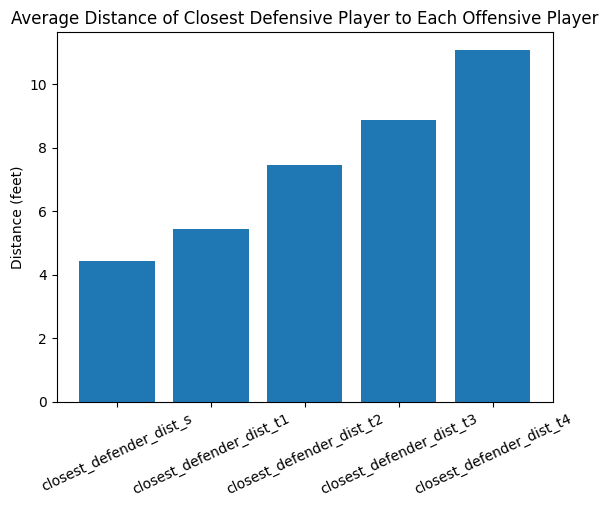

In [62]:
# make simple bar chart of this new feature

closest_defender_bar_chart_data = new_model_features.iloc[:,[28,29,30,31,32]].mean()
x_labels = ['closest_defender_dist_s', 'closest_defender_dist_t1', 'closest_defender_dist_t2', 'closest_defender_dist_t3', 'closest_defender_dist_t4']

plt.bar(x_labels, closest_defender_bar_chart_data)
plt.xticks(rotation = 25)
plt.title('Average Distance of Closest Defensive Player to Each Offensive Player')
plt.ylabel('Distance (feet)')

In [63]:
# model with these extra features

desired_columns = list(range(1, 13)) + list(range(14, 24)) + list(range(26,33))
X = new_model_features.iloc[:, desired_columns]
y = new_model_features.iloc[:, 13]

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.75, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit model
model = GaussianNB()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_pred, y_test)
print('Accuracy score:', accuracy)

classification = classification_report(y_pred, y_test)
print(classification) 

# another very marginal increase

Accuracy score: 0.6448079231692677
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      4761
           1       0.38      0.37      0.37      1903

    accuracy                           0.64      6664
   macro avg       0.56      0.56      0.56      6664
weighted avg       0.64      0.64      0.64      6664



#### New Features Takeaways
- Again, there was a very marginal increase in the accuracy scores.

In [64]:
# up until this points takes a little under 10 minutes to run

### Zone feature
- According to much research, it is a known fact that offensive boards are more likley to occur for players who are on the opposite side of the shooter
- To account for this in our statistical modeling, we will add a 'zone' feature to denote which zone the shooter is in
- a 1 will denote a player who is below the y = 20 coordinate, 2 is in between y =20,30, and 3 is above y=30.
- This feature will essentially count the number of offenisve players in the opposite zone

In [65]:
example_floor_oreb.head(10)

,id,court_x,court_y,annotation_code,is_oreb,team,opponent,conference,opp_conference,role,dist_from_hoop,which_hoop
0,2-2,72.807686,37.409669,d1,0,Kentucky,Duke,SEC,ACC,d,21.203196,1.0
1,2-2,79.080643,31.477796,d2,0,Kentucky,Duke,SEC,ACC,d,12.696228,1.0
2,2-2,69.956321,24.467300,d3,0,Kentucky,Duke,SEC,ACC,d,20.050756,1.0
3,2-2,75.468933,13.861763,d4,0,Kentucky,Duke,SEC,ACC,d,18.308802,1.0
4,2-2,84.973496,19.254422,d5,0,Kentucky,Duke,SEC,ACC,d,7.633964,1.0
5,2-2,69.994331,39.674616,s,0,Kentucky,Duke,SEC,ACC,o,24.810706,1.0
6,2-2,82.692421,32.736070,t1,0,Kentucky,Duke,SEC,ACC,o,10.641781,1.0
7,2-2,81.741959,17.097372,t2,0,Kentucky,Duke,SEC,ACC,o,11.430082,1.0
8,2-2,71.667114,12.603488,t3,0,Kentucky,Duke,SEC,ACC,o,22.130707,1.0
9,2-2,58.550842,12.962986,t4,0,Kentucky,Duke,SEC,ACC,o,33.674014,1.0


In [66]:
zone_set = example_floor_oreb
zone_set['zone'] = zone_set['court_y'].apply(lambda x: 1 if x <= 20 else (2 if 20 > x > 30 else 3))
zone_set

,id,court_x,court_y,annotation_code,is_oreb,team,opponent,conference,opp_conference,role,dist_from_hoop,which_hoop,zone
0,2-2,72.807686,37.409669,d1,0,Kentucky,Duke,SEC,ACC,d,21.203196,1.0,3
1,2-2,79.080643,31.477796,d2,0,Kentucky,Duke,SEC,ACC,d,12.696228,1.0,3
2,2-2,69.956321,24.467300,d3,0,Kentucky,Duke,SEC,ACC,d,20.050756,1.0,3
3,2-2,75.468933,13.861763,d4,0,Kentucky,Duke,SEC,ACC,d,18.308802,1.0,1
4,2-2,84.973496,19.254422,d5,0,Kentucky,Duke,SEC,ACC,d,7.633964,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
308045,5020-52,70.669644,7.270347,s,0,San Diego St.,Connecticut,MWC,BigEast,o,26.229816,1.0,1
308046,5020-52,86.958520,4.382292,t1,0,San Diego St.,Connecticut,MWC,BigEast,o,20.840837,1.0,1
308047,5020-52,58.962087,26.764930,t2,0,San Diego St.,Connecticut,MWC,BigEast,o,31.088053,1.0,3
308048,5020-52,76.777949,20.427222,t3,0,San Diego St.,Connecticut,MWC,BigEast,o,13.990459,1.0,3


In [67]:
def count_off_players_in_same_zone(group):
    shooter_zone = group.iloc[5,:]
    shooter_zone = shooter_zone['zone']
    counter = 0
    for i, player in group.iterrows():
        if player['role'] == 'o':
            if player['zone'] == shooter_zone:
                counter += 1
    group['not_same_zone_as_shooter'] = 5-counter
    return group

# i takes the row index, and the player takes the row itself

In [68]:
zone_same_as_shooter_count = zone_set.groupby('id').apply(count_off_players_in_same_zone)
# took about 1 minute to run

C:\Users\jacob\AppData\Local\Temp\ipykernel_13464\284503767.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zone_same_as_shooter_count = zone_set.groupby('id').apply(count_off_players_in_same_zone)


In [69]:
# make sure it worked, and rop the double index

zone_same_as_shooter_count = zone_same_as_shooter_count.droplevel(level=0)
zone_same_as_shooter_count

,id,court_x,court_y,annotation_code,is_oreb,team,opponent,conference,opp_conference,role,dist_from_hoop,which_hoop,zone,not_same_zone_as_shooter
360,10-10,16.757017,22.535605,d1,0,Duke,Army,ACC,Patriot League,d,12.992872,0.0,3,4
361,10-10,20.172220,25.303751,d2,0,Duke,Army,ACC,Patriot League,d,16.175073,0.0,3,4
362,10-10,13.667048,22.228054,d3,0,Duke,Army,ACC,Patriot League,d,10.056615,0.0,3,4
363,10-10,11.552852,30.378756,d4,0,Duke,Army,ACC,Patriot League,d,9.272356,0.0,3,4
364,10-10,12.853857,36.837769,d5,0,Duke,Army,ACC,Patriot League,d,14.782542,0.0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40825,999-5,89.955131,45.804170,s,0,St. John's,DePaul,BigEast,BigEast,o,20.804219,1.0,3,2
40826,999-5,70.668906,39.104168,t1,0,St. John's,DePaul,BigEast,BigEast,o,23.929454,1.0,3,2
40827,999-5,84.431093,25.006945,t2,0,St. John's,DePaul,BigEast,BigEast,o,5.568911,1.0,3,2
40828,999-5,68.482551,18.500774,t3,0,St. John's,DePaul,BigEast,BigEast,o,22.477556,1.0,1,2


In [70]:
zone_same_as_shooter_count_holder = zone_same_as_shooter_count.iloc[:,[0,13]]
zone_same_as_shooter_count_holder

,id,not_same_zone_as_shooter
360,10-10,4
361,10-10,4
362,10-10,4
363,10-10,4
364,10-10,4
...,...,...
40825,999-5,2
40826,999-5,2
40827,999-5,2
40828,999-5,2


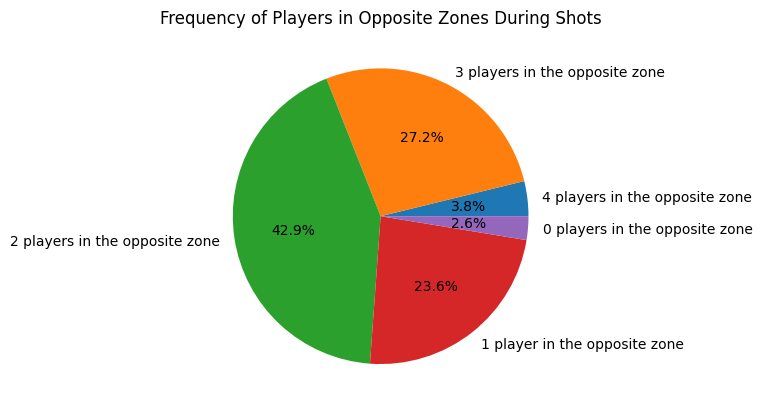

In [71]:
# make a pie chart of which outcome is the most common

zone_visual = zone_same_as_shooter_count_holder.value_counts('not_same_zone_as_shooter')
zone_visual = zone_visual.sort_index(ascending=False)
names = ['4 players in the opposite zone','3 players in the opposite zone','2 players in the opposite zone','1 player in the opposite zone','0 players in the opposite zone']

# make the pie chart
plt.pie(zone_visual, labels=names, autopct='%1.1f%%')
plt.title('Frequency of Players in Opposite Zones During Shots')
plt.show()

In [72]:
# merge the new features into the new features matrix

zone_features = pd.merge(new_model_features, zone_same_as_shooter_count_holder, on='id')

#### Zone Feature Takeaways
- Adding this feature dropped the overally accuracy score by about 4%, but it raised the offensive rebound prediction accuracy by 7%
- Because there are so many less offensive boards than defensive boards, it is a lot harder to accurately predict offensive bvoards vs. defensive boards, so I see this as a good outcome

# 5.) Model Experimentation
- Now that we have engineered multiple features (over 30 features now), we can move onto modeling.
- We are trying to predict whether an offensive board occurs on a given play, so this is obviously a classification problem
    - For this classification, I will be using 4 different classifiers
        - Gaussian Naive Bayes Classifier
            - This is one of the simplest classifiers. It works great with big data sets
        - Logistic Regression
            - This model is simple and easy to interpret
            - It is also efficient and works well with big data
        - Random Forest Classifier
            - This is an ensemble ML model that creates decision trees
            - You can also measure feature importance wtih this model
            - Generally a slower model, but has the potential to be more accurate
        - XGBoost Classifier
            - XGBoost is a robust ML model that can handle massive amounts of data
            - Generally slower than GNB and Logistic Regression, but can be incredibly accurate

In [108]:
# Pre process data for ML models

desired_columns = list(range(1, 13)) + list(range(14, 24)) + list(range(26,34))
X = zone_features.iloc[:, desired_columns]
y = zone_features.iloc[:, 13]

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.75, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [74]:
# Function that calculates cross validation score for each ML model

def cross_val_model_score(model, X_, y_):
    #perform cross-validation
    cross_val_scores = cross_val_score(model, X_, y_, cv=5, scoring='neg_log_loss')

    # since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
    log_loss_scores = -cross_val_scores
    return log_loss_scores.mean()

In [75]:
# Function that calcualtes the log loss of each ML model

def evaluate_models(models_dict, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models_dict.items():
        results[name] = cross_val_model_score(model, X_test, y_test)
    return results
        

In [120]:
# Function that outputs classification reports for each ML model

def evaluate_classification_report(models_dict, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models_dict.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        results[name] = pd.DataFrame(report).transpose()
    return results

In [76]:
# Classic ML models that I am using

models = {
    'XGBoost': xgb.XGBClassifier(learning_rate=0.065),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Gaussian Naive Bayes': GaussianNB()
}
df_results = evaluate_models(models, X_train, y_train, X_test, y_test)
# takes like 5 minutes to run

C:\Users\jacob\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jacob\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [77]:
df_results

{'XGBoost': 0.5087574010188325,
 'Random Forest': 0.14819139548419233,
 'Logistic Regression': 0.5744925071807317,
 'Gaussian Naive Bayes': 0.8886990128828713}

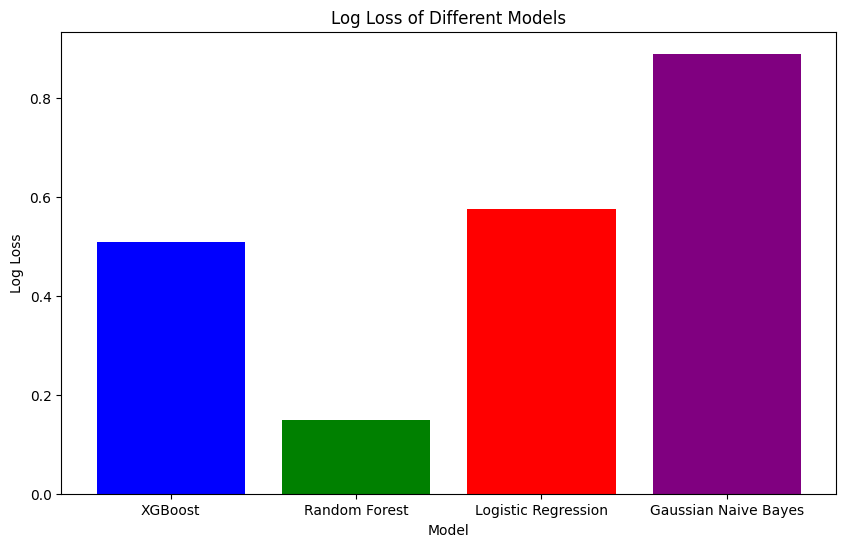

In [78]:
# Bar chart of the log loss of each ML model

models = list(df_results.keys())
log_loss_values = list(df_results.values())

plt.figure(figsize=(10, 6))
plt.bar(models, log_loss_values, color=['blue', 'green', 'red', 'purple'])
plt.title('Log Loss of Different Models')
plt.xlabel('Model')
plt.ylabel('Log Loss')
plt.show()

In [121]:
# Classic ML models that I am using

models = {
    'XGBoost': xgb.XGBClassifier(learning_rate=0.065),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Gaussian Naive Bayes': GaussianNB()
}

classification_report_results = evaluate_classification_report(models, X_train, y_train, X_test, y_test)

C:\Users\jacob\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [123]:
# Function that makes the output of the classification report more readable

def display_classification_reports(results):
    for name, df in results.items():
        print(f"Classification Report for {name}:\n")
        print(df.to_string())
        print("\n" + "="*80 + "\n")

In [124]:
display_classification_reports(classification_report_results)

Classification Report for XGBoost:

              precision    recall  f1-score       support
0              0.749437  0.997128  0.855719  48393.000000
1              0.938304  0.115855  0.206244  18247.000000
accuracy       0.755822  0.755822  0.755822      0.755822
macro avg      0.843871  0.556491  0.530982  66640.000000
weighted avg   0.801152  0.755822  0.677883  66640.000000


Classification Report for Random Forest:

              precision    recall  f1-score      support
0              1.000000  0.999752  0.999876  48393.00000
1              0.999343  1.000000  0.999671  18247.00000
accuracy       0.999820  0.999820  0.999820      0.99982
macro avg      0.999671  0.999876  0.999774  66640.00000
weighted avg   0.999820  0.999820  0.999820  66640.00000


Classification Report for Logistic Regression:

              precision    recall  f1-score     support
0              0.726876  0.993966  0.839693  48393.0000
1              0.372043  0.009481  0.018491  18247.0000
accuracy    

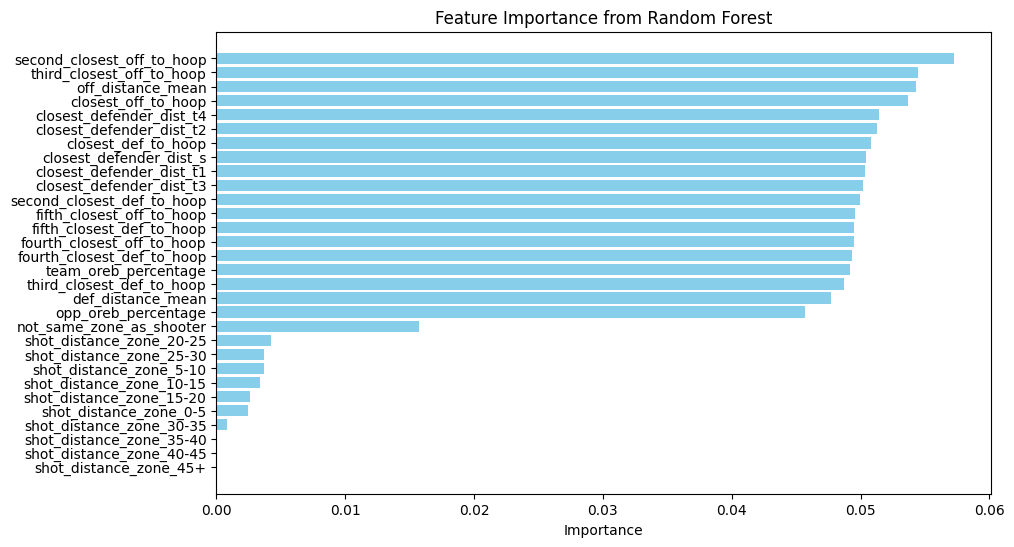

In [135]:
# Random Forest Classifier Feature Importances

feature_names = X_train.columns

model = RandomForestClassifier()
model.fit(X_train, y_train)

importances = model.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # To have the most important feature on top
plt.show()

### Model Experimentation Takeaways:
- The Random Forest Model performs exceptionally well
- It outperforms the other three models by a tremendous margin - it is not even close
- It predicts with a 99% accuracy which is wildy accurate 
- The most important features in the Random Forest Classifier model are the features that are about being clsoe to the hoop or closet to a defender
- Not surprisingly, the least important features are the shot distance features, with the further zones being even less important.

## Tuning Hyperparameters

In [79]:
param_grid = {
        'max_depth': [3],
        'min_child_weight': [4, 5],
        'n_estimators': [87, 100, 112],
        'learning_rate': [.045, .055, .06, .065]
    }

# create an instance of the XGBClassifier with a fixed learning rate and number of boosting rounds
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# use GridSearchCV to search for the best combination of hyperparameters
grid_search_xgb = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=5)
grid_search_xgb.fit(X_train, y_train)

# get the best hyperparameters from the grid search
best_params = grid_search_xgb.best_params_

In [80]:
best_params # best parameters for XGBoost

{'learning_rate': 0.065,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 112}

In [81]:
tuned_models = {
    'XGBoost': xgb.XGBClassifier(learning_rate=0.065, max_depth = 3, min_child_weight = 5, m_estimators=112),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Gaussian Naive Bayes': GaussianNB()
}
df_results = evaluate_models(tuned_models, X_train, y_train, X_test, y_test)
df_results

C:\Users\jacob\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [15:55:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "m_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\jacob\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [15:55:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "m_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\jacob\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [15:55:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "m_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\jacob\anaconda3\lib\site-packages\xgboost\core.py

{'XGBoost': 0.5608161547427379,
 'Random Forest': 0.1479569030878015,
 'Logistic Regression': 0.5744925071807317,
 'Gaussian Naive Bayes': 0.8886990128828713}

In [82]:
df_results

{'XGBoost': 0.5608161547427379,
 'Random Forest': 0.1479569030878015,
 'Logistic Regression': 0.5744925071807317,
 'Gaussian Naive Bayes': 0.8886990128828713}

# 6.) Convolutional Neural Network (CNN)
- We now implement a CNN to predict offensive rebounds on given plays
- Often times, when representing spatial data in tabular format, you may lose some of the data's intracacies
- CNNs may be more useful for this more spatial data

In [83]:
def create_court_grid(court_width, court_height):
    '''
    Create an empty court grid with higher resolution and multiple channels for each play.

    Parameters
    ----------
    court_width : int
        The width of the court grid in the desired higher resolution. For example, the width in inches or feet.

    court_height : int
        The height of the court grid in the desired higher resolution. For example, the height in inches or feet.

    Returns
    -------
    numpy.ndarray
        A 3D NumPy array representing the court grid with high resolution and three channels.
        The dimensions of the array are (court_height, court_width, 3),
        where the three channels represent shooter, offense, and defense.

    Example
    --------
    >>> court_width_inches = 500
    >>> court_height_inches = 940
    >>> grid = create_court_grid(court_width_inches, court_height_inches)
    >>> print(grid.shape)
    (940, 500, 3)
    '''
    return np.zeros((court_height, court_width, 4))



def place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height):
    '''
    Place player positions on the court grid with higher resolution and channels for shooter, offense, and defense.

    Parameters
    ----------
    court_grid : numpy.ndarray
        A 3D NumPy array representing the court grid with higher resolution and three channels.
        The array has dimensions (court_height_inches, court_width_inches, 3), where the three channels
        represent shooter, offense, and defense.

    player_positions : numpy.ndarray
        A 2D NumPy array containing the X and Y coordinates of the player positions.

    shooter_index : int
        The index of the shooter in the player_positions array.

    offense_indices : list
        A list of indices representing the players on offense in the player_positions array.

    defense_indices : list
        A list of indices representing the players on defense in the player_positions array.

    coordinate_multiplier : float
        The multiplier to convert the player positions from feet to the desired higher resolution (e.g., inches).

    Returns
    -------
    None
        This function modifies the court_grid in place, updating the shooter, offense, and defense channels
        based on the player_positions and corresponding indices.
    '''
    for i, (x, y) in enumerate(player_positions):
        x_dist = x * coordinate_multiplier
        y_dist = y * coordinate_multiplier
        if 0 <= x_dist < court_width and 0 <= y_dist < court_height:
            # finding the index of the shooter
            if i == np.argmax(shooter_index):
                court_grid[int(y_dist)][int(x_dist)][0] = 1  # Shooter channel
            # finding the indices of offensive players and comparing to the index
            if i in np.where(offense_indices == 1)[0]:
                court_grid[int(y_dist)][int(x_dist)][1] = 1  # Offense channel
            if i in np.where(defense_indices == 1)[0]:
                court_grid[int(y_dist)][int(x_dist)][2] = 1  # Defense channel
    return court_grid

In [84]:
# define the dimensions of the court grid with medium resolution
# depending on runtime, using lower resolution images may be a better approach here, but let's start with feet

coordinate_multiplier = 1
court_width = 94 * coordinate_multiplier
court_height = 50 * coordinate_multiplier

# derive parameters from the data table
player_positions_train = training_data[['court_x', 'court_y']].values
shooter_indices_train = training_data['shooter'].values
offense_indices_train = training_data['offense'].values
defense_indices_train = training_data['offense'].apply(lambda x: 0 if x == 1 else 1).values # Complement of 'offense' column gives 'defense' indices
which_hoop_train = training_data['which_hoop'].values

In [85]:
# derive parameters from the data table
player_positions_test = testing_data[['court_x', 'court_y']].values
shooter_indices_test = testing_data['shooter'].values
offense_indices_test = testing_data['offense'].values
defense_indices_test = testing_data['offense'].apply(lambda x: 0 if x == 1 else 1).values # Complement of 'offense' column gives 'defense' indices
which_hoop_test = testing_data['which_hoop'].values

In [86]:
# # create image-like training examples with higher resolution and multiple channels
X_train_images = []
# # reshaping organizes the positions into a list of list of coordinates, so there is one training example per play
for index, (player_positions, shooter_index, offense_indices, defense_indices, which_hoop_indices) in enumerate(zip(player_positions_train.reshape(-1, 10, 2), shooter_indices_train.reshape(-1, 10), offense_indices_train.reshape(-1, 10), defense_indices_train.reshape(-1, 10), which_hoop_train.reshape(-1, 10))):
    court_grid = create_court_grid(court_width, court_height)
    place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height)
    which_hoop = which_hoop_indices[0]
    if which_hoop == 0:
        court_grid[25][4][3] = 1 # basketball hoop channel
    else:
        court_grid[25][90][3] = 1
    X_train_images.append(court_grid)

In [88]:
X_train_images = np.array(X_train_images)

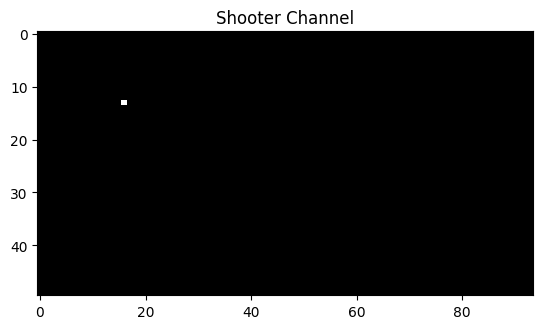

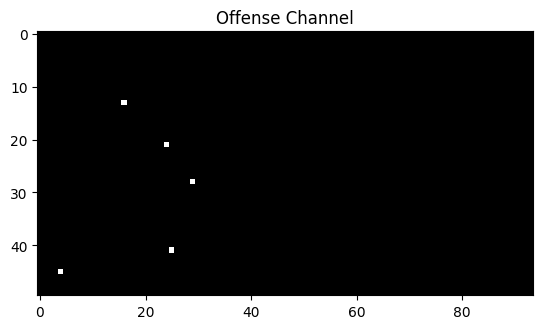

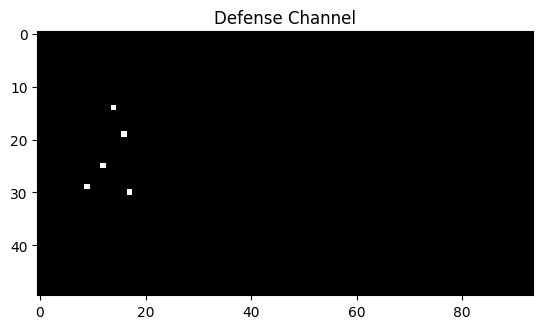

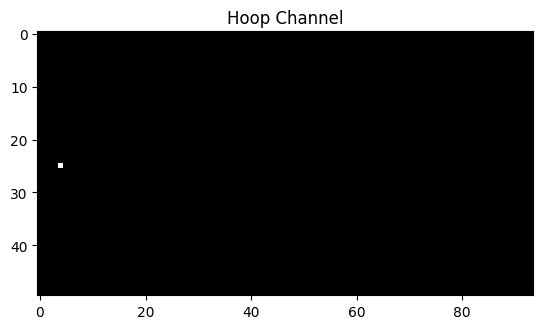

In [89]:
sample_index = 1
# visualize the shooter channel
plt.imshow(X_train_images[sample_index, :, :, 0], cmap='gray')
plt.title('Shooter Channel')
plt.show()

# visualize the offense channel
plt.imshow(X_train_images[sample_index, :, :, 1], cmap='gray')
plt.title('Offense Channel')
plt.show()

# visualize the defense channel
plt.imshow(X_train_images[sample_index, :, :, 2], cmap='gray')
plt.title('Defense Channel')
plt.show()

# visualize the basketball hoop channel
plt.imshow(X_train_images[sample_index, :, :, 3], cmap='gray')
plt.title('Hoop Channel')
plt.show()

In [90]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_images, train_pbp['is_oreb'], test_size=0.2, random_state=42)

In [93]:
  
# define the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 94, 4)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01)))
model.add(layers.Dense(1, activation='sigmoid'))  # sigmoid activation for binary classification

# compile the model with log loss (binary cross-entropy)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train the model
batch_size = 32
epochs = 10

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

# evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss (Log Loss): {loss:.4f}, Validation Accuracy: {accuracy:.4f}')

# takes about 10 minutes to run

C:\Users\jacob\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.7141 - loss: 0.6730 - val_accuracy: 0.7174 - val_loss: 0.5994
Epoch 2/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 50s 65ms/step - accuracy: 0.7143 - loss: 0.6001 - val_accuracy: 0.7174 - val_loss: 0.5954
Epoch 3/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.7208 - loss: 0.5892 - val_accuracy: 0.7174 - val_loss: 0.5936
Epoch 4/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.7220 - loss: 0.5853 - val_accuracy: 0.7174 - val_loss: 0.5939
Epoch 5/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 48s 62ms/step - accuracy: 0.7246 - loss: 0.5792 - val_accuracy: 0.7174 - val_loss: 0.5922
Epoch 6/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 50s 65ms/step - accuracy: 0.7174 - loss: 0.5880 - val_accuracy: 0.7174 - val_loss: 0.5901
Epoch 7/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 48s 62ms/step - accuracy: 0.7148 - loss: 0.5891 - val_accuracy: 0.7174 - val_loss: 0.5905
Epoch 8/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 49s 64ms/step - accuracy: 0.7133 - loss: 0.5895 - 

In [94]:
loss

0.5918797254562378

In [95]:
accuracy

0.717415988445282

#### CNN Model Takeaways
- It performs relatively average compared to the classic machine learning models
- The log loss of 0.59 ranks above Gaussian Naive Bayes, but below Random Forest, XGBoost, and Logistic Regression
- This is a pretty elementary model, and there is a lot of room to add more complexity to this neural network, and I plan to revisit this after I learn more about deep learning and neural networks!

# 7.) Conclusion

#### RESULTS:
Here are the log loss of each model that I used  
  
1.) Random Forest - 0.1480  
2.) XGBoost - 0.5088  
3.) Logistic Regression - 0.5745  
4.) CNN - 0.5866  
5.) Gaussian Naive Bayes - 0.8887  

Random Forest was the clear winner in terms of log loss. By taking a look at the table below, it was also the clear winner in terms of accuracy score and in terms of offensive rebound prediction


In [126]:
display_classification_reports(classification_report_results)

Classification Report for XGBoost:

              precision    recall  f1-score       support
0              0.749437  0.997128  0.855719  48393.000000
1              0.938304  0.115855  0.206244  18247.000000
accuracy       0.755822  0.755822  0.755822      0.755822
macro avg      0.843871  0.556491  0.530982  66640.000000
weighted avg   0.801152  0.755822  0.677883  66640.000000


Classification Report for Random Forest:

              precision    recall  f1-score      support
0              1.000000  0.999752  0.999876  48393.00000
1              0.999343  1.000000  0.999671  18247.00000
accuracy       0.999820  0.999820  0.999820      0.99982
macro avg      0.999671  0.999876  0.999774  66640.00000
weighted avg   0.999820  0.999820  0.999820  66640.00000


Classification Report for Logistic Regression:

              precision    recall  f1-score     support
0              0.726876  0.993966  0.839693  48393.0000
1              0.372043  0.009481  0.018491  18247.0000
accuracy    

#### Key Insights

Here are some key insights that will increase the odds of grabbing an offensive boards:
  
1.) Have many players near the basket  
2.) Be on the opposite side of the shooter  
3.) The further a defensive is from an offensive palyer, the more likely there is to be an offensive board  

#### Closing
  
In this project, we explored an NCAA basketball play by play dataset, and using that data, we trained models to predict which kinds of plays lead to offensive boards.

For the future, here are some things that I would like to improve on:

1.) Add more complexity to the neural network section  
2.) Tune hyperparameters further (the power of my PC limited me in this regard)  
3.) Bring in more data on each team.  
    - Knowing exactly how good each team, or each conference is at rebounding could have been an extremely valuable feature  
4.) Explore Graph Neural Networks (GNNs)

Overall, I am very happy with this project and the results, and I hope to build similar projects in the future!